In [1]:
# MOD per system
import sys
sys.path.append('C:/Users/emiga/OneDrive/Cal/GWs/code/holodeck') 


# %load ../init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import os
import sys
import logging
import warnings
import numpy as np
import astropy as ap
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
import kalepy.utils
import kalepy.plot

import holodeck as holo
import holodeck.sam
from holodeck import cosmo, utils, plot
from holodeck.constants import MSOL, PC, YR, MPC, GYR

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode
plt.rcParams.update({'grid.alpha': 0.5})

log = holo.log
log.setLevel(logging.INFO)

# 1. Functions

In [2]:
def gws_by_loops(edges, number, realize, round = False, sum=False, print_test = False):
       
    """ Inefficient way to calculate strain from numbered 
    grid integrated

    Parameters
    ----------
    edges : (4,) list of 1darrays
        A list containing the edges along each dimension.  The four dimensions correspond to
        total mass, mass ratio, redshift, and observer-frame orbital frequency.
        The length of each of the four arrays is M, Q, Z, F.
    number : (M-1, Q-1, Z-1, F-1) ndarray
        The number of binaries in each bin of parameter space.  This is calculated by integrating
        `dnum` over each bin.
    realize : bool or int,
        Specification of how to construct one or more discrete realizations.
        If a `bool` value, then whether or not to construct a realization.
        If a `int` value, then how many discrete realizations to construct.
    round : bool
        Specification of whether to discretize the sample if realize is False, 
        by rounding number of binaries in each bin to integers. This has no impact 
        if realize is true.
        NOTE: should add a warning if round and realize are both True
    print_test : bool
        Whether or not to print variables as they are calculated, for dev purposes.


    Returns
    -------
    hc_grid : ndarray
        Characteristic strain of the GWB.
        The shape depends on whether realize is an integer or not
        realize = True or False: shape is (M-1, Q-1, Z-1, F-1)
        realize = R: shape is  (M-1, Q-1, Z-1, F-1, R)

    """
    if(print_test):
        print('INPUTS: edges:', len(edges), '\n', edges, 
        '\nINPUTS:number:', number.shape, '\n', number,'\n')

    # Frequency bin midpoints
    foo = edges[-1]                   #: should be observer-frame orbital-frequencies
    df = np.diff(foo)                 #: frequency bin widths
    fc = kale.utils.midpoints(foo)    #: use frequency-bin centers for strain (more accurate!)

    # All other bin midpoints
    mt = kale.utils.midpoints(edges[0]) #: total mass
    mr = kale.utils.midpoints(edges[1]) #: mass ratio
    rz = kale.utils.midpoints(edges[2]) #: redshift

    
    # make strain grid
    hc_grid = np.empty_like(number)

    # for r realizations, make a grid with shape 
    # m, q, z, f, r
    if(utils.isinteger(realize)):
        newshape = hc_grid.shape + (realize,)
        if(print_test):
            print('newshape:', newshape)
        realized_grid = np.empty(newshape)

    # get strain for each bin
    for m_idx in range(len(mt)):
        for q_idx in range(len(mr)):
            cmass = holo.utils.chirp_mass_mtmr(mt[m_idx], mr[q_idx])
            for z_idx in range(len(rz)):
                cdist = holo.cosmo.comoving_distance(rz[z_idx]).cgs.value
                
                # print M, q, z, M_c, d_c
                if(print_test):
                    print('BIN mt=%.2e, mr=%.2e, rz=%.2e' %
                        (mt[m_idx], mr[q_idx], rz[z_idx]))
                    print('\t m_c = %.2e, d_c = %.2e' 
                        % (cmass, cdist))

                for f_idx in range(len(fc)):
                    rfreq = holo.utils.frst_from_fobs(fc[f_idx], rz[z_idx])
                    hs_mqzf = utils.gw_strain_source(cmass, cdist, rfreq)
                    hc_dlnf = hs_mqzf**2 * (fc[f_idx]/df[f_idx])
                    
                    if(realize == False):
                        if(round == True):
                            hc_grid[m_idx, q_idx, z_idx, f_idx] = np.sqrt(hc_dlnf 
                                        * np.floor(number[m_idx, q_idx, z_idx, f_idx]).astype(int))
                        else:
                            hc_grid[m_idx, q_idx, z_idx, f_idx] = np.sqrt(hc_dlnf 
                                        * number[m_idx, q_idx, z_idx, f_idx])
                        
                    elif(realize == True):
                        hc_grid[m_idx, q_idx, z_idx, f_idx] = np.sqrt(hc_dlnf 
                                        *np.random.poisson(number[m_idx, q_idx, z_idx, f_idx]))
                    elif(utils.isinteger(realize)):
                        for r_idx in range(realize):
                            realized_grid[m_idx, q_idx, z_idx, f_idx, r_idx] = \
                                np.sqrt(hc_dlnf 
                                        *np.random.poisson(number[m_idx, q_idx, z_idx, f_idx]))
                        hc_grid = realized_grid                
                    else:
                        print("`realize` ({}) must be one of {{True, False, integer}}!"\
                            .format(realize))

                     # print fr, hs, hc^2/dlnf, number, hc
                    if(print_test):
                        print('\t\tfr = %.2fnHz, h_s = %.2e, h_c^2/dlnf = %.2e' 
                            % (rfreq*10**9, hs_mqzf, hc_dlnf))
                        print('\t\tnumber: %.2e' % number[m_idx, q_idx, z_idx, f_idx])
                        print('\t\thc = %.2e' % hc_grid[m_idx, q_idx, z_idx, f_idx])
    if(sum):
        # sum over all bins at a given frequency and realization
        hc_grid = np.sqrt(np.sum(hc_grid**2, axis=(0, 1, 2)))

    
    return hc_grid


In [3]:
def gws_by_ndars(edges, number, realize, round = False, sum = False, print_test = False):
       
    """ More efficient way to calculate strain from numbered 
    grid integrated

    Parameters
    ----------
    edges : (4,) list of 1darrays
        A list containing the edges along each dimension.  The four dimensions 
        correspond to total mass, mass ratio, redshift, and observer-frame orbital 
        frequency. The length of each of the four arrays is M, Q, Z, F.
    number : (M-1, Q-1, Z-1, F-1) ndarray
        The number of binaries in each bin of parameter space.  This is calculated 
        by integrating `dnum` over each bin.
    realize : bool or int
        Specification of how to construct one or more discrete realizations.
        If a `bool` value, then whether or not to construct a realization.
        If an `int` value, then how many discrete realizations to construct.
    round : bool
        Specification of whether to discretize the sample if realize is False, 
        by rounding number of binaries in each bin to integers. This has no impact 
        if realize is true.
        NOTE: should add a warning if round and realize are both True
    sum : bool
        Whether or not to sum the strain at a given frequency over all bins.
    print_test : bool
        Whether or not to print variable as they are calculated, for dev purposes.


    Returns
    -------
    hchar : ndarray
        Characteristic strain of the GWB.
        The shape depends on whether realize is an integer or not
        realize = True or False, sum = False: shape is (M-1, Q-1, Z-1, F-1)
        realize = True or False, sum = True: shape is (F-1)
        realize = R, sum = False: shape is  (M-1, Q-1, Z-1, F-1, R)
        realize = R, sum = True: shape is  (F-1, R)

    """

    if(print_test):
        print('INPUTS: edges:', len(edges), # '\n', edges, 
        '\nINPUTS:number:', number.shape, '\n', number,'\n')

    # Frequency bin midpoints
    foo = edges[-1]                   #: should be observer-frame orbital-frequencies
    df = np.diff(foo)                 #: frequency bin widths
    fc = kale.utils.midpoints(foo)    #: use frequency-bin centers for strain (more accurate!)

    # All other bin midpoints
    mt = kale.utils.midpoints(edges[0]) #: total mass
    mr = kale.utils.midpoints(edges[1]) #: mass ratio
    rz = kale.utils.midpoints(edges[2]) #: redshift


    # --- Chirp Masses ---
    # to get chirp mass in shape (M-1, Q-1) we need 
    # mt in shape (M-1, 1) 
    # mr in shape (1, Q-1)
    cmass = utils.chirp_mass_mtmr(mt[:,np.newaxis], mr[np.newaxis,:])
    if(print_test):
        print('cmass:', cmass.shape, '\n', cmass)

    # --- Comoving Distances ---
    # to get cdist in shape (Z-1) we need
    # rz in shape (Z-1)
    cdist = holo.cosmo.comoving_distance(rz).cgs.value
    if(print_test):
        print('cdist:', cdist.shape, '\n', cdist)

    # --- Rest Frame Frequencies ---
    # to get rest freqs in shape (Z-1, F-1) we need 
    # rz in shape (Z-1, 1) 
    # fc in shape (1, F-1)
    rfreq = holo.utils.frst_from_fobs(fc[np.newaxis,:], rz[:,np.newaxis])
    if(print_test):
        print('rfreq:', rfreq.shape, '\n', rfreq)

    # --- Source Strain Amplitude ---
    # to get hs amplitude in shape (M-1, Q-1, Z-1, F-1) we need
    # cmass in shape (M-1, Q-1, 1, 1) from (M-1, Q-1)
    # cdist in shape (1, 1, Z-1, 1) from (Z-1)
    # rfreq in shape (1, 1, Z-1, F-1) from (Z-1, F-1)
    hsamp = utils.gw_strain_source(cmass[:,:,np.newaxis,np.newaxis],
                                   cdist[np.newaxis,np.newaxis,:,np.newaxis],
                                   rfreq[np.newaxis,np.newaxis,:,:])
    if(print_test):
        print('hsamp', hsamp.shape, '\n', hsamp)

    # --- Characteristic Strain Squared ---
    # to get characteristic strain in shape (M-1, Q-1, Z-1, F-1) we need
    # hsamp in shape (M-1, Q-1, Z-1, F-1)
    # fc in shape (1, 1, 1, F-1)
    hchar = hsamp**2 * (fc[np.newaxis, np.newaxis, np.newaxis,:]
                        /df[np.newaxis, np.newaxis, np.newaxis,:])

    # Sample:
    if(realize == False):
        # without sampling, want strain in shape (M-1, Q-1, Z-1, F-1)
        if(round): 
            # discretize by rounding number down to nearest integer 
            hchar *= np.floor(number).astype(int) 
        else: 
            # keep non-integer values
            hchar *= number

    if(realize == True):
        # with a single sample, want strain in shape (M-1, Q-1, Z-1, F-1)
        hchar *= np.random.poisson(number)

    if(utils.isinteger(realize)):
        # with R realizations, 
        # to get strain in shape (M-1, Q-1, Z-1, F-1, R) we need
        # hchar in shape(M-1, Q-1, Z-1, F-1, 1)
        # Poisson sample in shape (1, 1, 1, 1, R)
        npois = np.random.poisson(number[...,np.newaxis], size = (number.shape + (realize,)))
        if(print_test):
            print('npois', npois.shape)
        hchar = hchar[...,np.newaxis] * npois


    if(print_test):
        print('hchar', hchar.shape, '\n', hchar)


    if(sum):
        # sum over all bins at a given frequency and realization
        hchar = np.sum(hchar, axis=(0, 1, 2))
        # NOTE I should check what big O time this is,  not sure
        if(print_test):
            print('hchar summed', hchar.shape, '\n', hchar)

    return np.sqrt(hchar)

# 2. Example (Lenovo)

## 2.1 Calculate Strains
### Choose the frequency bins at which to calculate the GWB
same as in semi-analytic-models.ipynb

In [4]:
dur = 5.0*YR/3.1557600
cad = .5*YR/3.1557600
fobs = utils.nyquist_freqs(dur,cad)
fobs_edges = utils.nyquist_freqs_edges(dur,cad)
print(f"Number of frequency bins: {fobs.size-1}")
print(f"  between [{fobs[0]*YR:.2f}, {fobs[-1]*YR:.2f}] 1/yr")
print(f"          [{fobs[0]*1e9:.2f}, {fobs[-1]*1e9:.2f}] nHz")

Number of frequency bins: 4
  between [0.63, 3.16] 1/yr
          [20.00, 100.00] nHz


### Build Semi-Analytic-Model with super simple parameters 

In [5]:
mtot=(1.0e6*MSOL/1.988409870698051, 1.0e8*MSOL/1.988409870698051, 3)
mrat=(1e-1, 1.0, 2)
redz=(1e-3, 1.0, 4)
sam = holo.sam.Semi_Analytic_Model(mtot, mrat, redz)
print('edges:', sam.edges)

edges: [array([1.e+39, 1.e+40, 1.e+41]), array([0.1, 1. ]), array([0.001, 0.01 , 0.1  , 1.   ])]


### Get SAM edges and numbers as in sam.gwb()

In [6]:
# get observed orbital frequency bin edges and centers 
# from observed GW frequency bin edges
# f_orb = f_GW/2
fobs_orb_edges = fobs_edges / 2.0
fobs_orb_cents = kale.utils.midpoints(fobs_edges) / 2.0

# dynamic_binary_number
# gets differential number of binaries per bin-vol per log freq interval
edges, dnum = sam.dynamic_binary_number(holo.hardening.Hard_GW, fobs_orb=fobs_orb_cents)
edges[-1] = fobs_orb_edges

# integrate (multiply by bin volume) within each bin
number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
number = number * np.diff(np.log(fobs_edges))

### Calculate strain by three methods
1) Using gravwaves._gws_from_number_grid_integrated()
2) Using gws_by_loops() (above)
3) Using gws_by_ndars() (above)

In [7]:
# 1. Get GWB spectrum using gravwaves._gws_from_number_grid_integrated()

# without sampling
hc_samF = holo.gravwaves._gws_from_number_grid_integrated(edges, number, realize=False, sum=False) 
hc_samF_sum = holo.gravwaves._gws_from_number_grid_integrated(edges, number, realize=False, sum=True)

# for many realizations
hc_sam30 = holo.sam.gravwaves._gws_from_number_grid_integrated(edges, number, realize=30, sum=False)
hc_sam30_sum = holo.sam.gravwaves._gws_from_number_grid_integrated(edges, number, realize=30, sum=True)

In [8]:
# 2. Get GWB spectrum using gws_by_loops()

# without sampling
hc_loopF = gws_by_loops(edges, number, realize=False, sum=False)  
hc_loopF_sum = gws_by_loops(edges, number, realize=False, sum=True)   
 
# for many realizations
hc_loop30 = gws_by_loops(edges, number, realize=30, sum=False)  
hc_loop30_sum = gws_by_loops(edges, number, realize=30, sum=True)   

# without sampling, but discretized
hc_loopR = gws_by_loops(edges, number, realize=False, round=True, sum=False)  
hc_loopR_sum = gws_by_loops(edges, number, realize=False, round=True, sum=True)  

In [9]:
# 3. Get GWB spectrum using gws_by_ndars()

# without sampling
hc_ndarF = gws_by_ndars(edges, number, realize=False, sum=False)  
hc_ndarF_sum = gws_by_ndars(edges, number, realize=False, sum=True)   
 
# for many realizations
hc_ndar30 = gws_by_ndars(edges, number, realize=30, sum=False)  
hc_ndar30_sum = gws_by_ndars(edges, number, realize=30, sum=True)  

# without sampling, but discretized
hc_ndarR = gws_by_ndars(edges, number, realize=False, round=True, sum=False)  
hc_ndarR_sum = gws_by_ndars(edges, number, realize=False, round=True, sum=True) 

## 2.2 Compare Results

### Check unsampled strain distributions
Should match to machine precision

In [10]:
assert (hc_loopF == hc_samF).all, "Loop strains don't match SAM."
assert (hc_loopF_sum == hc_samF_sum).all, "Loop strain sums don't match SAM."
assert (hc_ndarF == hc_samF).all, "Ndar strains don't match SAM."
assert (hc_ndarF_sum == hc_samF_sum).all, "Ndar strain sums don't match SAM."
assert (hc_ndarR == hc_loopR).all, "Rounded ndar strains don't match loop."
assert (hc_ndarR_sum == hc_loopR_sum).all, "Rounded ndar strain sums don't match loop."
assert (hc_ndarR != hc_ndarF).all, "Rounded ndar strains matchs non-rounded ndar. \
    They shouldn't."
assert (hc_ndarR_sum != hc_loopF_sum).all, "Rounded ndar strain sums match non-rounded \
    ndar. They shouldn't"

In [11]:
# strain for each M, q, z, and f bin
print(hc_samF == hc_ndarF)
# should be exact same
# print('hc by sam:\n', hc_samF)
# print('hc by loop:\n', hc_loopF)

[[[[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]]]


 [[[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]]]]


note that the 'rounded' cases are not strains rounded to integers,
but rather the strain calculated with a rounded integer number per bin

In [12]:
print(hc_loopR == hc_ndarR)
print(hc_loopR%1) # strains don't have to be integers, 
                  # just the numbers used to calculate them do

[[[[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]]]


 [[[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]]]]
[[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
    0.00000000e+00]
   [9.05664895e-17 5.50186355e-17 4.17348515e-17 3.43800826e-17
    2.87027279e-17]
   [1.47251517e-16 8.94545057e-17 6.78565780e-17 5.58988529e-17
    4.66682722e-17]]]


 [[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
    0.00000000e+00]
   [4.69028744e-16 2.84927969e-16 2.16088633e-16 1.77976953e-16
    1.48513588e-16]
   [7.42198910e-16 4.50881659e-16 3.42020288e-16 2.81749061e-16
    2.35222562e-16]]]]


note: worth checking this with a larger grid

### Plot multiple realizations vs frequency

In [13]:
def add_sampleGWB_to_plot(fig, ax, PLOT_GWB, LABEL, COLOR='b'):
    nsamp = PLOT_GWB.shape[1]
    ax.plot(xx, np.median(PLOT_GWB, axis=1), color=COLOR, label=LABEL)
    # plot contours at 50% and 98% confidence intervals
    for pp in [50, 98]:
        percs = pp / 2
        percs = [50 - percs, 50 + percs]
        ax.fill_between(xx, *np.percentile(PLOT_GWB, percs, axis=-1), alpha=0.25, color=COLOR)
    # Plot `nsamp` random spectra 
    
    idx = np.random.choice(PLOT_GWB.shape[1], nsamp, replace=False)
    ax.plot(xx, PLOT_GWB[:, idx], lw=1.0, alpha=0.5, color=COLOR, linestyle = 'dotted')

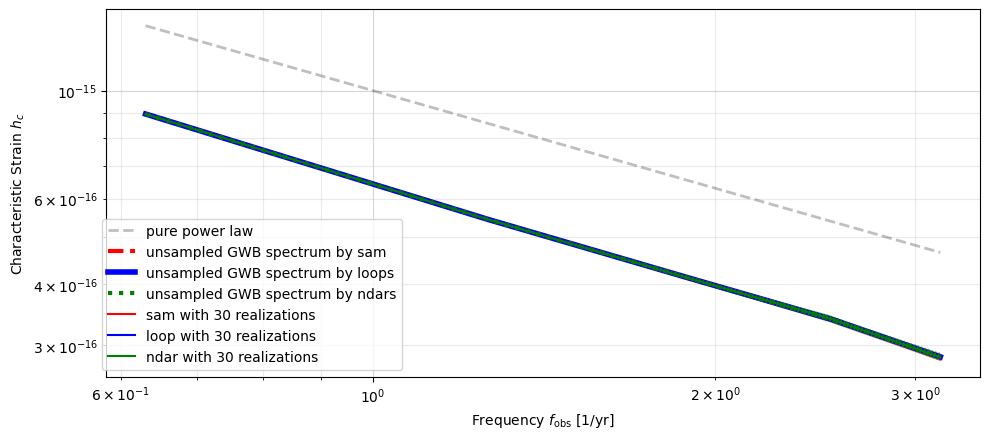

In [14]:
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])

xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot the model without sampling
# blue: my loop method
# green: my ndar method
# red: the sam method
ax.plot(xx, hc_samF_sum, color='r', lw=3, ls = 'dashed', label='unsampled GWB spectrum by sam')
ax.plot(xx, hc_loopF_sum, color='b', lw=4, ls = 'solid', label='unsampled GWB spectrum by loops')
ax.plot(xx, hc_ndarF_sum, color='g', lw=3, ls = 'dotted', label='unsampled GWB spectrum by ndars')

# plot the model with Poisson sampling
add_sampleGWB_to_plot(fig, ax, hc_sam30_sum, LABEL='sam with 30 realizations', COLOR='r')
add_sampleGWB_to_plot(fig, ax, hc_loop30_sum, LABEL='loop with 30 realizations', COLOR='b')
add_sampleGWB_to_plot(fig, ax, hc_ndar30_sum, LABEL='ndar with 30 realizations', COLOR='g')

# plot single realizations
# ax.plot(xx, hc_loop10_sum[:, 0], lw=4.0, alpha=0.6, color='green', linestyle = 'dotted',
#         label = 'loop realization')
# ax.plot(xx, hc_sam10_sum[:, 0], lw=4.0, alpha=0.6, color='purple', linestyle = 'dotted',
#         label = 'sam realization')


legend_gwb = ax.legend(bbox_to_anchor=(.1,.15), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()

this is uninteresting for my super simple example, but they do look the same

### Rounded number strains

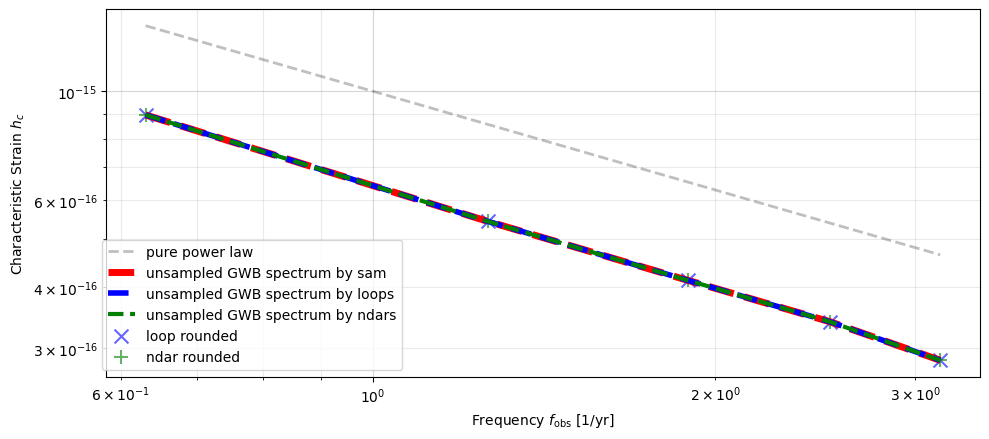

In [15]:
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])

xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot the model without sampling
# blue: my loop method
# green: my ndar method
# red: the sam method
ax.plot(xx, hc_samF_sum, color='r', lw=5, ls = 'dashed', label='unsampled GWB spectrum by sam')
ax.plot(xx, hc_loopF_sum, color='b', lw=4, ls = 'dashed', label='unsampled GWB spectrum by loops')
ax.plot(xx, hc_ndarF_sum, color='g', lw=3, ls = 'dashed', label='unsampled GWB spectrum by ndars')

# plot the model with Poisson sampling
# add_sampleGWB_to_plot(fig, ax, hc_sam30_sum, LABEL='sam with 30 realizations', COLOR='r')
# add_sampleGWB_to_plot(fig, ax, hc_loop30_sum, LABEL='loop with 30 realizations', COLOR='b')
# add_sampleGWB_to_plot(fig, ax, hc_ndar30_sum, LABEL='ndar with 30 realizations', COLOR='g')

# plot rounded numbers
# ax.plot(xx, hc_loopR_sum, lw=4, color='b', linestyle = 'dotted',
#         label = 'loop rounded')
# ax.plot(xx, hc_ndarR_sum, lw=3, color='g', linestyle = 'dotted',
#         label = 'ndar rounded')
ax.scatter(xx, hc_loopR_sum, marker='x', s = 100, alpha=.6, color='b', 
        label = 'loop rounded')
ax.scatter(xx, hc_ndarR_sum, marker='+', s=100, alpha=.6, color='g',
        label = 'ndar rounded')


legend_gwb = ax.legend(bbox_to_anchor=(.1,.15), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()

In [16]:
print(number)

[[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
    0.00000000e+00]
   [8.82745690e+06 6.46423553e+05 1.44416576e+05 5.00858751e+04
    2.77638151e+04]
   [1.09390698e+09 8.01054307e+07 1.78962414e+07 6.20668998e+06
    3.44051876e+06]]]


 [[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
    0.00000000e+00]
   [1.09892126e+05 8.04726202e+03 1.79782747e+03 6.23514038e+02
    3.45628951e+02]
   [1.28993591e+07 9.44603826e+05 2.11032610e+05 7.31893338e+04
    4.05706225e+04]]]]


### Compare realization standard deviations

In [17]:
std_sam = np.std(hc_sam30_sum, axis=1)
std_loop = np.std(hc_loop30_sum, axis=1)
std_ndar = np.std(hc_ndar30_sum, axis=1)
print(np.max(np.abs(std_ndar-std_sam)))
print(np.max(np.abs(std_ndar/std_sam)))
print(std_ndar.shape)

6.005428470997898e-19
1.338256442463057
(5,)


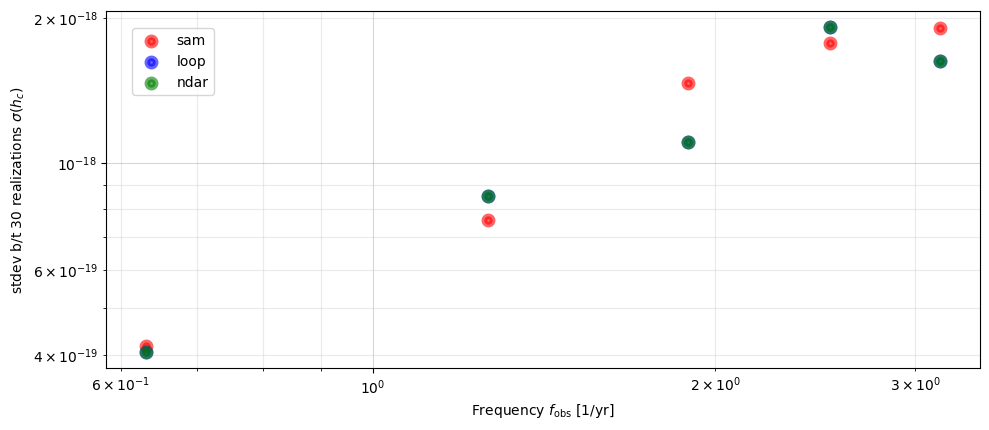

In [18]:
# Plot the stdevs
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel=r'stdev b/t 30 realizations $\sigma(h_c)$', figsize=[10,4.5])

xx = fobs * YR

# # plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
# yy = 1e-15 * np.power(xx, -2.0/3.0)
# ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot single realizations
ax.scatter(xx, std_sam, lw=4.0, alpha=0.6, color='red', 
        label = 'sam')
ax.scatter(xx, std_loop, lw=4.0, alpha=0.6, color='blue', 
        label = 'loop')
ax.scatter(xx, std_loop, lw=4.0, alpha=0.6, color='green', 
        label = 'ndar')


legend_gwb = ax.legend(bbox_to_anchor=(.13,.92), bbox_transform=fig.transFigure, loc='upper left')
fig.tight_layout()

### Compare IQR

In [19]:
# applying to my data
Q75_sam, Q25_sam = np.percentile(hc_sam30_sum, [75 ,25], axis=1)
IQR_sam = Q75_sam-Q25_sam
Q75_loop, Q25_loop = np.percentile(hc_loop30_sum, [75 ,25], axis=1)
IQR_loop = Q75_loop-Q25_loop
Q75_ndar, Q25_ndar = np.percentile(hc_ndar30_sum, [75 ,25], axis=1)
IQR_ndar = Q75_ndar-Q25_ndar
print(np.max(np.abs(IQR_loop-IQR_sam)))
print(np.max(np.abs(IQR_loop/IQR_sam)))
print(np.min(np.abs(IQR_loop/IQR_sam)))

print(np.max(np.abs(IQR_ndar-IQR_sam)))
print(np.max(np.abs(IQR_ndar/IQR_sam)))
print(np.min(np.abs(IQR_ndar/IQR_sam)))
print(IQR_loop.shape)

1.3657248403105824e-18
1.3607345347070776
0.390025714802985
1.1606284574917946e-18
1.870320191410109
0.8493919163234717
(5,)


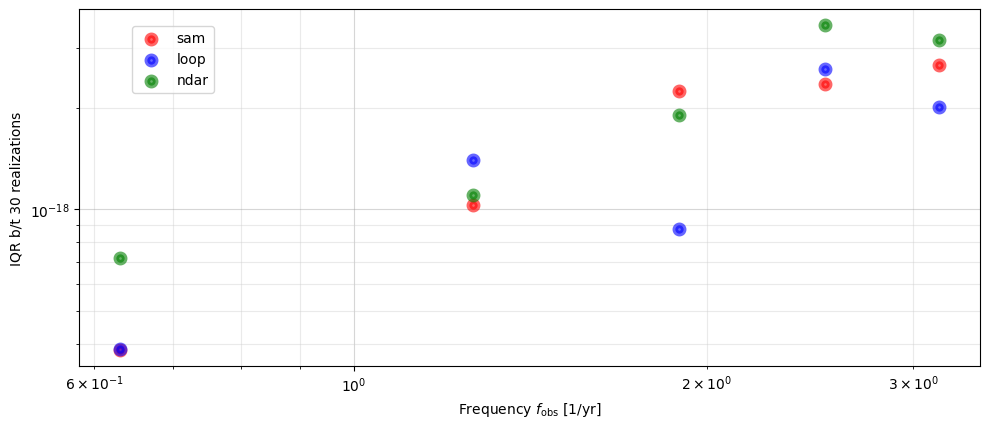

In [20]:
# Plot the IQRs
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel=r'IQR b/t 30 realizations', figsize=[10,4.5])

xx = fobs * YR

# # plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
# yy = 1e-15 * np.power(xx, -2.0/3.0)
# ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot single realizations
ax.scatter(xx, IQR_sam, lw=4.0, alpha=0.6, color='red', 
        label = 'sam')
ax.scatter(xx, IQR_loop, lw=4.0, alpha=0.6, color='blue', 
        label = 'loop')
ax.scatter(xx, IQR_ndar, lw=4.0, alpha=0.6, color='green', 
        label = 'ndar')


legend_gwb = ax.legend(bbox_to_anchor=(.13,.92), bbox_transform=fig.transFigure, loc='upper left')
fig.tight_layout()

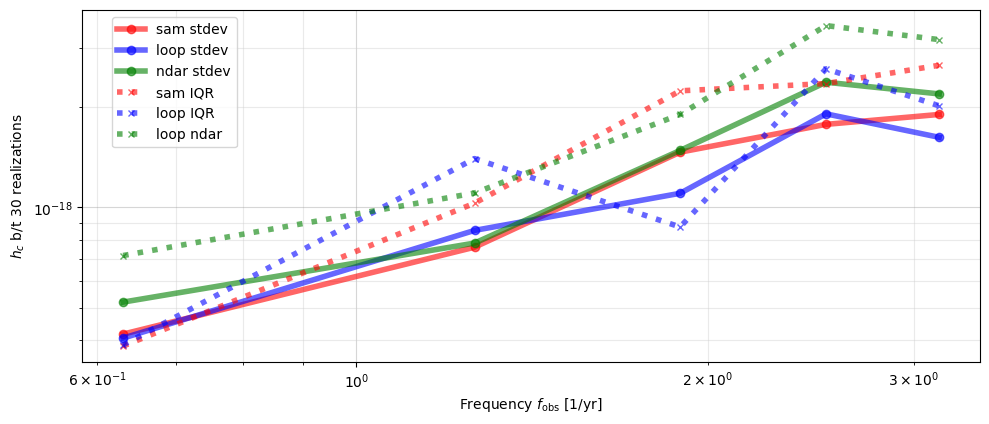

In [21]:
# IQR and Stdev 
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel=r'$h_c$ b/t 30 realizations', figsize=[10,4.5])

xx = fobs * YR

# # plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
# yy = 1e-15 * np.power(xx, -2.0/3.0)
# ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')


ax.plot(xx, std_sam, lw=4.0, alpha=0.6, color='red', 
        label = 'sam stdev', marker='o', linestyle = 'solid')
ax.plot(xx, std_loop, lw=4.0, alpha=0.6, color='blue', 
        label = 'loop stdev', marker='o', linestyle = 'solid')
ax.plot(xx, std_ndar, lw=4.0, alpha=0.6, color='green', 
        label = 'ndar stdev', marker='o', linestyle = 'solid')


ax.plot(xx, IQR_sam, lw=4.0, alpha=0.6, color='red', 
        label = 'sam IQR', marker = 'x', ms = 5, linestyle='dotted')
ax.plot(xx, IQR_loop, lw=4.0, alpha=0.6, color='blue', 
        label = 'loop IQR', marker = 'x', ms=5, linestyle = 'dotted')
ax.plot(xx, IQR_ndar, lw=4.0, alpha=0.6, color='green', 
        label = 'loop ndar', marker = 'x', ms=5, linestyle = 'dotted')

legend_gwb = ax.legend(bbox_to_anchor=(.11,.93), bbox_transform=fig.transFigure, loc='upper left')
fig.tight_layout()

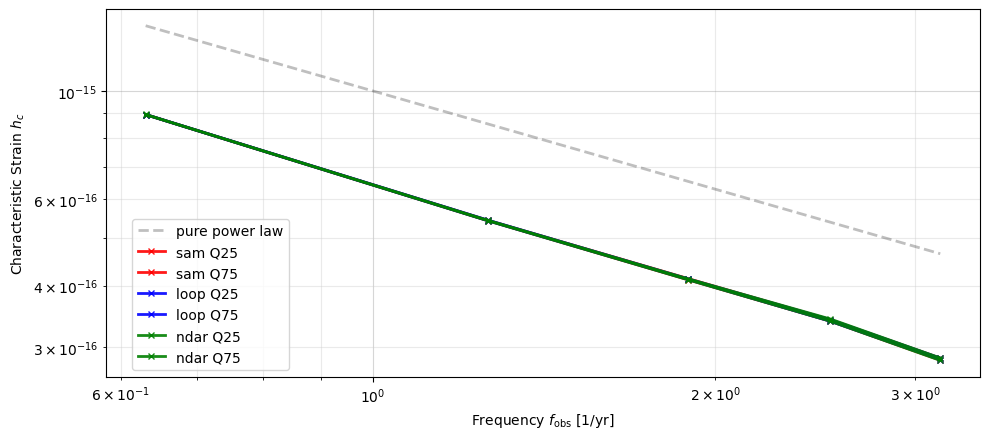

In [22]:
# Plot percentiles
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])

xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot the model without sampling
# blue: my loop method
# red: the sam method
# ax.plot(xx, hc_loopF_sum, color='b', lw=4, ls = 'solid', label='unsampled GWB spectrum2 by loops')
# ax.plot(xx, hc_samF_sum, color='r', lw=3, ls = 'dashed', label='unsampled GWB spectrum2 by sam')

# plot just 25th and 75th percentile
ax.plot(xx, Q25_sam, lw=2.0, alpha=.9, color='red', 
        label = 'sam Q25', marker = 'x', ms=5, linestyle = 'solid')
ax.plot(xx, Q75_sam, lw=2.0, alpha=.9, color='red', 
        label = 'sam Q75', marker = 'x', ms=5, linestyle = 'solid')
ax.fill_between(xx, Q25_sam, Q75_sam, alpha=0.2, color='red')


ax.plot(xx, Q25_loop, lw=2.0, alpha=.9, color='blue', 
        label = 'loop Q25', marker = 'x', ms=5, linestyle = 'solid')
ax.plot(xx, Q75_loop, lw=2.0, alpha=.9, color='blue', 
        label = 'loop Q75', marker = 'x', ms=5, linestyle = 'solid')
ax.fill_between(xx, Q25_loop, Q75_loop, alpha=0.2, color='blue')


ax.plot(xx, Q25_ndar, lw=2.0, alpha=.9, color='green', 
        label = 'ndar Q25', marker = 'x', ms=5, linestyle = 'solid')
ax.plot(xx, Q75_ndar, lw=2.0, alpha=.9, color='green', 
        label = 'ndar Q75', marker = 'x', ms=5, linestyle = 'solid')
ax.fill_between(xx, Q25_ndar, Q75_ndar, alpha=0.2, color='green')

legend_gwb = ax.legend(bbox_to_anchor=(.13,.15), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()

## 2.3 Check impact of strain rounding

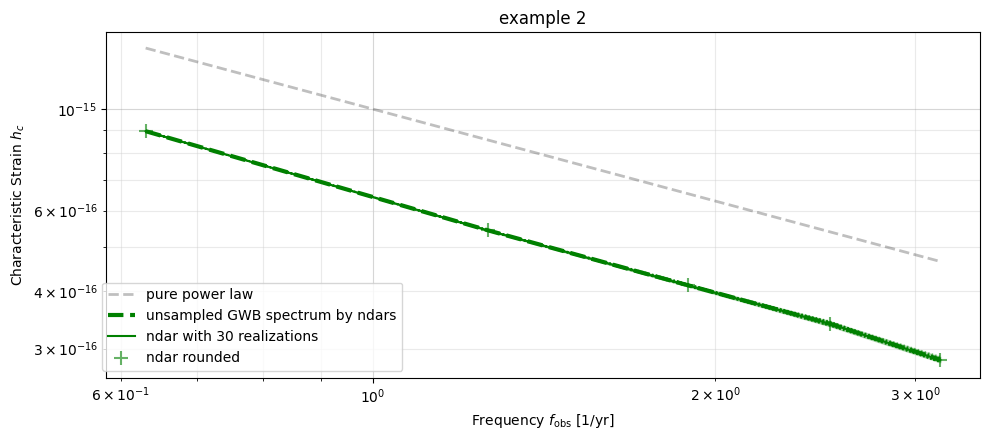

In [23]:
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])
ax.set_title('example 2')

xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot the model without sampling
ax.plot(xx, hc_ndarF_sum, color='g', lw=3, ls = 'dashed', label='unsampled GWB spectrum by ndars')

# plot the model with Poisson sampling
add_sampleGWB_to_plot(fig, ax, hc_ndar30_sum, LABEL='ndar with 30 realizations', COLOR='g')

# plot rounded numbers
ax.scatter(xx, hc_ndarR_sum, marker='+', s=100, alpha=.6, color='g',
        label = 'ndar rounded')


# plot single realizations
# ax.plot(xx, hc_ndar30_sum[:, 0], lw=2.0, alpha=0.6, color='green', linestyle = 'dotted',
#         label = 'ndar realization')

legend_gwb = ax.legend(bbox_to_anchor=(.1,.15), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()

NameError: name 'roundtozero' is not defined

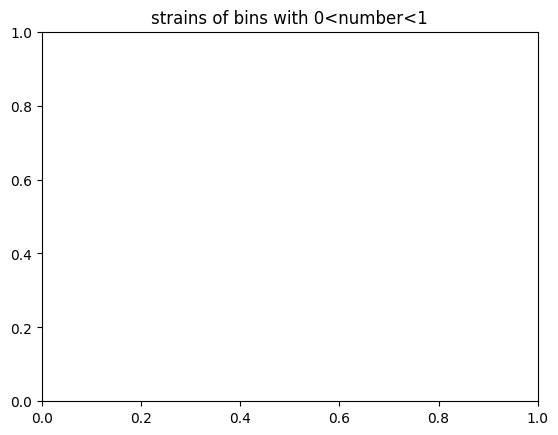

In [24]:
roundedstrains = hc_ndarF[((number>0) & (number<1))]
plt.title('strains of bins with 0<number<1')
plt.scatter(roundtozero, roundedstrains,  s=.5)
plt.xlabel('prerounded number value')
plt.ylabel('strain')
# plt.yscale('log')
# plt.xscale('log')

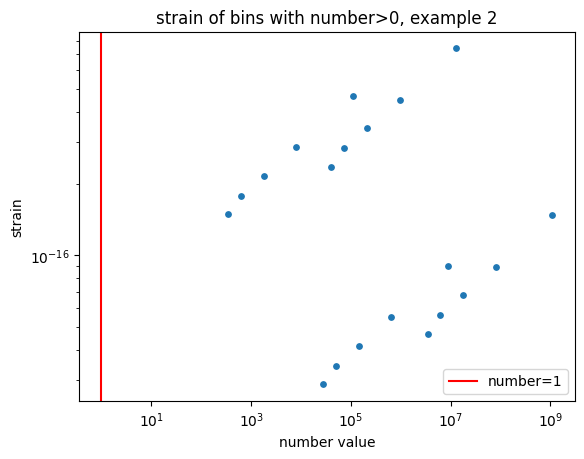

In [ ]:
plt.scatter(number[number>0], hc_ndarF[((number>0))], s=15)
plt.title('strain of bins with number>0, example 2')
plt.xlabel('number value')
plt.ylabel('strain')
plt.xscale('log')
plt.yscale('log')
plt.axvline(1, color='red', label='number=1')
plt.legend()

##### Number dependence on parameters

In [ ]:
print(edges[0].shape)
print(number.shape)
# masses are first index of number
print(hc_loopF.shape)
mt = kale.utils.midpoints(edges[0]) #: total mass
mr = kale.utils.midpoints(edges[1]) #: mass ratio
rz = kale.utils.midpoints(edges[2]) #: redshift

ones = np.ones(number.shape)
masses = (mt[:,np.newaxis,np.newaxis,np.newaxis]*ones).flatten()
ratios = (mr[np.newaxis,:,np.newaxis,np.newaxis]*ones).flatten()
shifts = (rz[np.newaxis,np.newaxis,:,np.newaxis]*ones).flatten()
strains = hc_loopF.flatten()

(25,)
(24, 24, 24, 5)
(24, 24, 24, 5)


In [ ]:
# Testing my flattening of arrays and correlating the right bin parameters to strains

x = np.array([[[1,2,3],[10,20,30]], [[4,5,6],[40,50,60]], [[7,8,9],[70,80,90]], [[10,11,12],[100,110,120]]])
y = np.array([1,10])
ones = np.ones(x.shape)
flatx = x.flatten()
print(flatx)
print((y[:,np.newaxis]*ones).flatten())
z = np.array([1,4,7,10])
print((z[:,np.newaxis, np.newaxis]*ones).flatten())
print(x.flatten())

fourd = np.array([[[[1],[2],[3]], [[11],[22],[33]]], [[[4],[5],[6]], [[44],[55],[66]]],
                  [[[10],[20],[30]], [[110],[220],[330]]], [[[40],[50],[60]], [[440],[550],[660]]]])
fourdones = np.ones(fourd.shape)
m = np.array([1,4,10,40])
q = np.array([1, 11])
z = np.array([1, 2, 3])
print(fourd.shape)
print(m.shape)
print(q.shape)
print(z.shape)
print(fourd.flatten())
print((m[:,np.newaxis,np.newaxis,np.newaxis]*fourdones).flatten())
print((q[np.newaxis,:, np.newaxis,np.newaxis]*fourdones).flatten())
print((z[np.newaxis,np.newaxis,np.newaxis,:]*ones).flatten())

[  1   2   3  10  20  30   4   5   6  40  50  60   7   8   9  70  80  90
  10  11  12 100 110 120]
[ 1.  1.  1. 10. 10. 10.  1.  1.  1. 10. 10. 10.  1.  1.  1. 10. 10. 10.
  1.  1.  1. 10. 10. 10.]
[ 1.  1.  1.  1.  1.  1.  4.  4.  4.  4.  4.  4.  7.  7.  7.  7.  7.  7.
 10. 10. 10. 10. 10. 10.]
[  1   2   3  10  20  30   4   5   6  40  50  60   7   8   9  70  80  90
  10  11  12 100 110 120]
(4, 2, 3, 1)
(4,)
(2,)
(3,)
[  1   2   3  11  22  33   4   5   6  44  55  66  10  20  30 110 220 330
  40  50  60 440 550 660]
[ 1.  1.  1.  1.  1.  1.  4.  4.  4.  4.  4.  4. 10. 10. 10. 10. 10. 10.
 40. 40. 40. 40. 40. 40.]
[ 1.  1.  1. 11. 11. 11.  1.  1.  1. 11. 11. 11.  1.  1.  1. 11. 11. 11.
  1.  1.  1. 11. 11. 11.]
[1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3.]


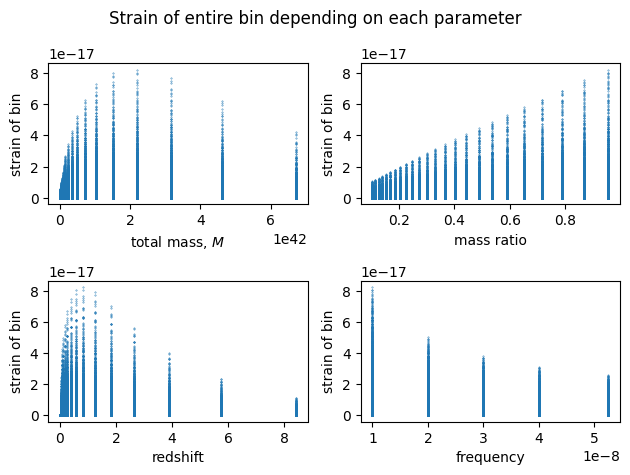

In [ ]:
mt = kale.utils.midpoints(edges[0]) #: total mass
mr = kale.utils.midpoints(edges[1]) #: mass ratio
rz = kale.utils.midpoints(edges[2]) #: redshift
fc = kale.utils.midpoints(edges[-1]) #: frequency bin centers

ones = np.ones(number.shape)
masses = (mt[:,np.newaxis,np.newaxis,np.newaxis]*ones)
ratios = (mr[np.newaxis,:,np.newaxis,np.newaxis]*ones)
shifts = (rz[np.newaxis,np.newaxis,:,np.newaxis]*ones)
ofreqs = (fc[np.newaxis,np.newaxis,np.newaxis,:]*ones)
strains = hc_loopF
numbers = number

fig, axs = plt.subplots(2,2)

fig.suptitle('Strain of entire bin depending on each parameter')
axs[0,0].scatter(masses, strains, s=.1)
axs[0,0].set_xlabel('total mass, $M$')
axs[0,0].set_ylabel('strain of bin')

axs[0,1].scatter(ratios, strains, s=.1)
axs[0,1].set_xlabel('mass ratio')
axs[0,1].set_ylabel('strain of bin')


axs[1,0].scatter(shifts, strains, s=.1)
axs[1,0].set_xlabel('redshift')
axs[1,0].set_ylabel('strain of bin')


axs[1,1].scatter(ofreqs, strains, s=.1)
axs[1,1].set_xlabel('frequency')
axs[1,1].set_ylabel('strain of bin')

fig.tight_layout()

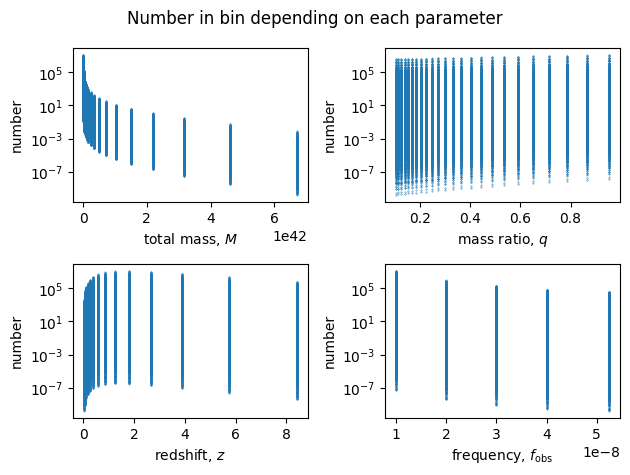

In [ ]:

fig, axs = plt.subplots(2,2)

fig.suptitle('Number in bin depending on each parameter')
axs[0,0].scatter(masses, numbers, s=.1)
axs[0,0].set_xlabel('total mass, $M$')
axs[0,0].set_ylabel('number')
axs[0,0].set_yscale('log')

axs[0,1].scatter(ratios, numbers, s=.1)
axs[0,1].set_xlabel('mass ratio, $q$')
axs[0,1].set_ylabel('number')
axs[0,1].set_yscale('log')

axs[1,0].scatter(shifts, numbers, s=.1)
axs[1,0].set_xlabel('redshift, $z$')
axs[1,0].set_ylabel('number')
axs[1,0].set_yscale('log')

axs[1,1].scatter(ofreqs, numbers, s=.1)
axs[1,1].set_xlabel('frequency, $f_\mathrm{obs}$')
axs[1,1].set_ylabel('number')
axs[1,1].set_yscale('log')

fig.tight_layout()

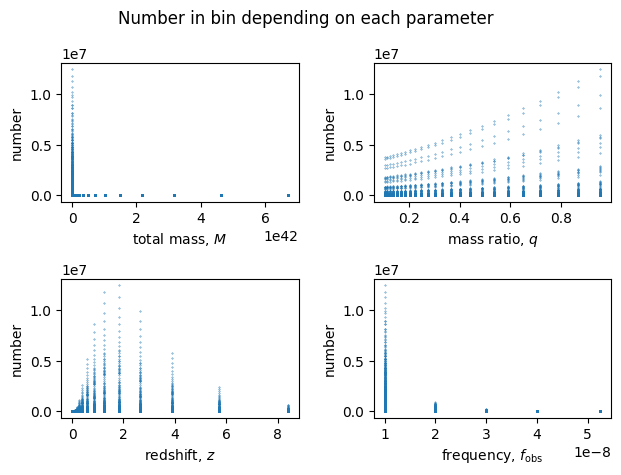

In [ ]:

fig, axs = plt.subplots(2,2)

fig.suptitle('Number in bin depending on each parameter')
axs[0,0].scatter(masses, numbers, s=.1)
axs[0,0].set_xlabel('total mass, $M$')
axs[0,0].set_ylabel('number')
# axs[0,0].set_yscale('log')

axs[0,1].scatter(ratios, numbers, s=.1)
axs[0,1].set_xlabel('mass ratio, $q$')
axs[0,1].set_ylabel('number')
# axs[0,1].set_yscale('log')

axs[1,0].scatter(shifts, numbers, s=.1)
axs[1,0].set_xlabel('redshift, $z$')
axs[1,0].set_ylabel('number')
# axs[1,0].set_yscale('log')

axs[1,1].scatter(ofreqs, numbers, s=.1)
axs[1,1].set_xlabel('frequency, $f_\mathrm{obs}$')
axs[1,1].set_ylabel('number')
# axs[1,1].set_yscale('log')

fig.tight_layout()

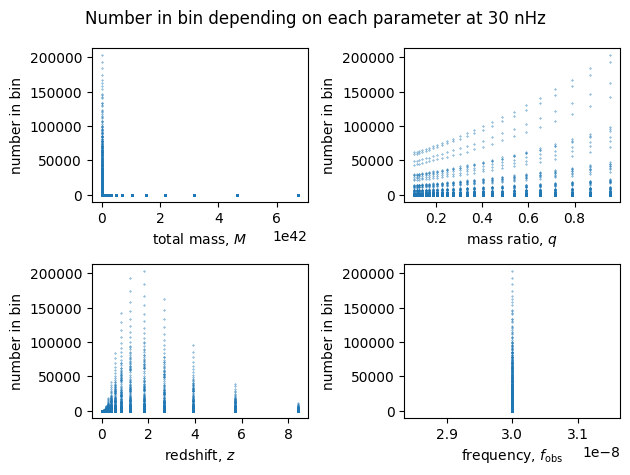

In [ ]:
masses_grid = (mt[:,np.newaxis,np.newaxis,np.newaxis]*ones)
ratios_grid = (mr[np.newaxis,:,np.newaxis,np.newaxis]*ones)
shifts_grid = (rz[np.newaxis,np.newaxis,:,np.newaxis]*ones)
ofreqs_grid = (fc[np.newaxis,np.newaxis,np.newaxis,:]*ones)
strains_grid = hc_loopF
numbers_grid = number

fig, axs = plt.subplots(2,2)

fig.suptitle('Number in bin depending on each parameter at %d nHz' % (ofreqs_grid[0,0,0,2]*10**9))
axs[0,0].scatter(masses[:,:,:,2], numbers[:,:,:,2], s=.1)
axs[0,0].set_xlabel('total mass, $M$')
axs[0,0].set_ylabel('number in bin')

axs[0,1].scatter(ratios[:,:,:,2], numbers[:,:,:,2], s=.1)
axs[0,1].set_xlabel('mass ratio, $q$')
axs[0,1].set_ylabel('number in bin')


axs[1,0].scatter(shifts[:,:,:,2], numbers[:,:,:,2], s=.1)
axs[1,0].set_xlabel('redshift, $z$')
axs[1,0].set_ylabel('number in bin')


axs[1,1].scatter(ofreqs[:,:,:,2], numbers[:,:,:,2], s=.1)
axs[1,1].set_xlabel('frequency, $f_\mathrm{obs}$')
axs[1,1].set_ylabel('number in bin')

fig.tight_layout()

In [ ]:


fig, axs = plt.subplots(2,2)

fig.suptitle('Number vs Mass with dif other params')
axs[0,0].scatter(mass_grid[], number_grid[], s=.1)
axs[0,0].set_xlabel('total mass, $M$')
axs[0,0].set_ylabel('number in bin')

axs[0,1].scatter(ratios, numbers, s=.1)
axs[0,1].set_xlabel('mass ratio')
axs[0,1].set_ylabel('strain of bin')


axs[1,0].scatter(shifts, numbers, s=.1)
axs[1,0].set_xlabel('redshift')
axs[1,0].set_ylabel('strain of bin')


axs[1,1].scatter(ofreqs, numbers, s=.1)
axs[1,1].set_xlabel('frequency')
axs[1,1].set_ylabel('strain of bin')

fig.tight_layout()

# 3. Slightly More Complex Example
Let's see what windows can handle. Limiting factor seems to be the total mass upper limit.

## 3.1 Calculate Strains
### Choose the frequency bins at which to calculate the GWB
same as in semi-analytic-models.ipynb

In [ ]:
dur = 5.0*YR/3.1557600
cad = .5*YR/3.1557600
fobs = utils.nyquist_freqs(dur,cad)
fobs_edges = utils.nyquist_freqs_edges(dur,cad)
print(f"Number of frequency bins: {fobs.size-1}")
print(f"  between [{fobs[0]*YR:.2f}, {fobs[-1]*YR:.2f}] 1/yr")
print(f"          [{fobs[0]*1e9:.2f}, {fobs[-1]*1e9:.2f}] nHz")

Number of frequency bins: 4
  between [0.63, 3.16] 1/yr
          [20.00, 100.00] nHz


### Build Semi-Analytic-Model with super simple parameters 

In [ ]:
mtot=(1.0e6*MSOL/1.988409870698051, 4.0e9*MSOL, 25)
mrat=(1e-1, 1.0, 25)
redz=(1e-3, 10.0, 25)
sam = holo.sam.Semi_Analytic_Model(mtot, mrat, redz)
print('edges:', sam.edges)

edges: [array([1.00000000e+39, 1.45386332e+39, 2.11371855e+39, 3.07305786e+39,
       4.46780610e+39, 6.49557941e+39, 9.44368463e+39, 1.37298267e+40,
       1.99612914e+40, 2.90209893e+40, 4.21925518e+40, 6.13422034e+40,
       8.91831794e+40, 1.29660153e+41, 1.88508140e+41, 2.74065071e+41,
       3.98453153e+41, 5.79296423e+41, 8.42217820e+41, 1.22446959e+42,
       1.78021143e+42, 2.58818409e+42, 3.76286592e+42, 5.47069273e+42,
       7.95363948e+42]), array([0.1       , 0.11006942, 0.12115277, 0.13335214, 0.14677993,
       0.16155981, 0.17782794, 0.19573418, 0.21544347, 0.23713737,
       0.26101572, 0.28729848, 0.31622777, 0.34807006, 0.38311868,
       0.4216965 , 0.46415888, 0.51089698, 0.56234133, 0.61896582,
       0.68129207, 0.74989421, 0.82540419, 0.90851758, 1.        ]), array([1.00000000e-03, 1.46779927e-03, 2.15443469e-03, 3.16227766e-03,
       4.64158883e-03, 6.81292069e-03, 1.00000000e-02, 1.46779927e-02,
       2.15443469e-02, 3.16227766e-02, 4.64158883e-02, 6.81292

### Get SAM edges and numbers as in sam.gwb()

In [ ]:
# get observed orbital frequency bin edges and centers 
# from observed GW frequency bin edges
# f_orb = f_GW/2
fobs_orb_edges = fobs_edges / 2.0
fobs_orb_cents = kale.utils.midpoints(fobs_edges) / 2.0

# dynamic_binary_number
# gets differential number of binaries per bin-vol per log freq interval
edges, dnum = sam.dynamic_binary_number(holo.hardening.Hard_GW, fobs_orb=fobs_orb_cents)
edges[-1] = fobs_orb_edges

# integrate (multiply by bin volume) within each bin
number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
number = number * np.diff(np.log(fobs_edges))

### Calculate strain by three methods
1) Using gravwaves._gws_from_number_grid_integrated()
2) Using gws_by_loops() (above)
3) Using gws_by_ndars() (above)

In [ ]:
# 1. Get GWB spectrum using gravwaves._gws_from_number_grid_integrated()

# without sampling
hc_samF = holo.gravwaves._gws_from_number_grid_integrated(edges, number, realize=False, sum=False) 
hc_samF_sum = holo.gravwaves._gws_from_number_grid_integrated(edges, number, realize=False, sum=True)

# for many realizations
hc_sam30 = holo.sam.gravwaves._gws_from_number_grid_integrated(edges, number, realize=30, sum=False)
hc_sam30_sum = holo.sam.gravwaves._gws_from_number_grid_integrated(edges, number, realize=30, sum=True)

In [ ]:
# 2. Get GWB spectrum using gws_by_loops()

# without sampling
hc_loopF = gws_by_loops(edges, number, realize=False, sum=False)  
hc_loopF_sum = gws_by_loops(edges, number, realize=False, sum=True)   
 
# for many realizations
hc_loop30 = gws_by_loops(edges, number, realize=30, sum=False)  
hc_loop30_sum = gws_by_loops(edges, number, realize=30, sum=True)   

# without sampling, but discretized
hc_loopR = gws_by_loops(edges, number, realize=False, round=True, sum=False)  
hc_loopR_sum = gws_by_loops(edges, number, realize=False, round=True, sum=True)  

In [ ]:
# 3. Get GWB spectrum using gws_by_ndars()

# without sampling
hc_ndarF = gws_by_ndars(edges, number, realize=False, sum=False)  
hc_ndarF_sum = gws_by_ndars(edges, number, realize=False, sum=True)   
 
# for many realizations
hc_ndar30 = gws_by_ndars(edges, number, realize=30, sum=False)  
hc_ndar30_sum = gws_by_ndars(edges, number, realize=30, sum=True)  

# without sampling, but discretized
hc_ndarR = gws_by_ndars(edges, number, realize=False, round=True, sum=False)  
hc_ndarR_sum = gws_by_ndars(edges, number, realize=False, round=True, sum=True) 

## 3.2 Compare Results

### Check unsampled strain distributions
Should match to machine precision

In [ ]:
assert (hc_loopF == hc_samF).all, "Loop strains don't match SAM."
assert (hc_loopF_sum == hc_samF_sum).all, "Loop strain sums don't match SAM."
assert (hc_ndarF == hc_samF).all, "Ndar strains don't match SAM."
assert (hc_ndarF_sum == hc_samF_sum).all, "Ndar strain sums don't match SAM."
assert (hc_ndarR == hc_loopR).all, "Rounded ndar strains don't match loop."
assert (hc_ndarR_sum == hc_loopR_sum).all, "Rounded ndar strain sums don't match loop."
assert (hc_ndarR != hc_ndarF).all, "Rounded ndar strains matchs non-rounded ndar. \
    They shouldn't."
assert (hc_ndarR_sum != hc_loopF_sum).all, "Rounded ndar strain sums match non-rounded \
    ndar. They shouldn't"

In [ ]:
# strain for each M, q, z, and f bin
print(hc_samF == hc_ndarF)
# should be exact same
# print('hc by sam:\n', hc_samF)
# print('hc by loop:\n', hc_loopF)

[[[[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   ...
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]]

  [[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   ...
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]]

  [[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   ...
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]]

  ...

  [[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   ...
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]]

  [[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   ...
   [ 

In [ ]:
print(np.all(hc_loopR == hc_ndarR))
print(hc_loopR[np.where(hc_loopR != hc_ndarR)] 
      - hc_ndarR[np.where(hc_loopR != hc_ndarR)])
print(hc_loopR[np.where(hc_loopR != hc_ndarR)] 
      / hc_ndarR[np.where(hc_loopR != hc_ndarR)])


False
[-2.40741243e-35 -4.81482486e-35  4.81482486e-35 -2.40741243e-35
  2.40741243e-35  1.20370622e-35 -9.62964972e-35  1.20370622e-35
 -9.62964972e-35  2.40741243e-35  9.62964972e-35 -2.40741243e-35
 -4.81482486e-35  2.40741243e-35 -2.40741243e-35 -1.92592994e-34
  1.92592994e-34  3.85185989e-34  3.85185989e-34  1.92592994e-34
  7.70371978e-34  3.85185989e-34  7.70371978e-34 -1.54074396e-33
  1.54074396e-33  3.08148791e-33]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


### Plot multiple realizations vs frequency

In [ ]:
def add_sampleGWB_to_plot(fig, ax, PLOT_GWB, LABEL, COLOR='b'):
    nsamp = PLOT_GWB.shape[1]
    ax.plot(xx, np.median(PLOT_GWB, axis=1), color=COLOR, label=LABEL)
    # plot contours at 50% and 98% confidence intervals
    for pp in [50, 98]:
        percs = pp / 2
        percs = [50 - percs, 50 + percs]
        ax.fill_between(xx, *np.percentile(PLOT_GWB, percs, axis=-1), alpha=0.25, color=COLOR)
    # Plot `nsamp` random spectra 
    
    idx = np.random.choice(PLOT_GWB.shape[1], nsamp, replace=False)
    ax.plot(xx, PLOT_GWB[:, idx], lw=1.0, alpha=0.5, color=COLOR, linestyle = 'dotted')

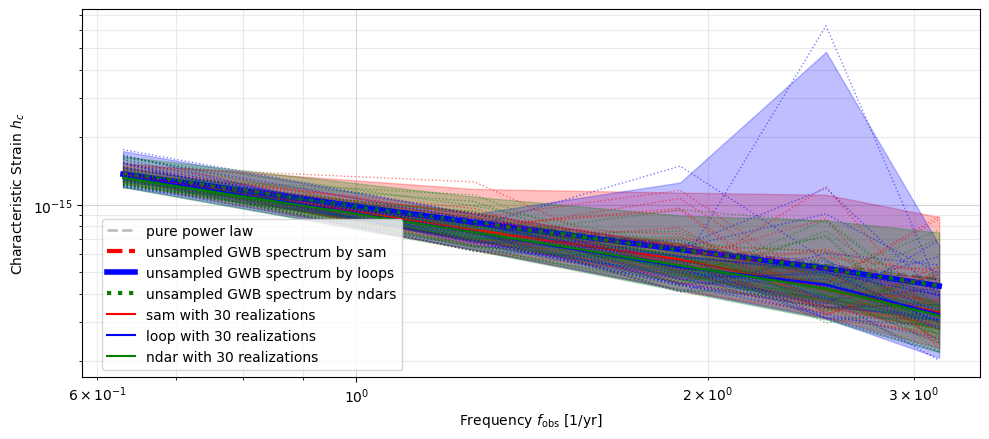

In [ ]:
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])

xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot the model without sampling
# blue: my loop method
# green: my ndar method
# red: the sam method
ax.plot(xx, hc_samF_sum, color='r', lw=3, ls = 'dashed', label='unsampled GWB spectrum by sam')
ax.plot(xx, hc_loopF_sum, color='b', lw=4, ls = 'solid', label='unsampled GWB spectrum by loops')
ax.plot(xx, hc_ndarF_sum, color='g', lw=3, ls = 'dotted', label='unsampled GWB spectrum by ndars')

# plot the model with Poisson sampling
add_sampleGWB_to_plot(fig, ax, hc_sam30_sum, LABEL='sam with 30 realizations', COLOR='r')
add_sampleGWB_to_plot(fig, ax, hc_loop30_sum, LABEL='loop with 30 realizations', COLOR='b')
add_sampleGWB_to_plot(fig, ax, hc_ndar30_sum, LABEL='ndar with 30 realizations', COLOR='g')

# plot single realizations
# ax.plot(xx, hc_loop10_sum[:, 0], lw=4.0, alpha=0.6, color='green', linestyle = 'dotted',
#         label = 'loop realization')
# ax.plot(xx, hc_sam10_sum[:, 0], lw=4.0, alpha=0.6, color='purple', linestyle = 'dotted',
#         label = 'sam realization')


legend_gwb = ax.legend(bbox_to_anchor=(.1,.15), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()

### Rounded number strains

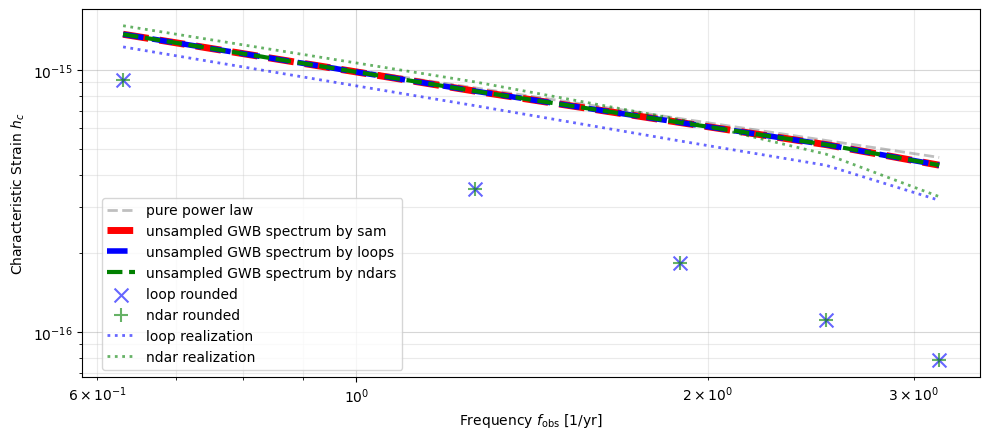

In [ ]:
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])

xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot the model without sampling
# blue: my loop method
# green: my ndar method
# red: the sam method
ax.plot(xx, hc_samF_sum, color='r', lw=5, ls = 'dashed', label='unsampled GWB spectrum by sam')
ax.plot(xx, hc_loopF_sum, color='b', lw=4, ls = 'dashed', label='unsampled GWB spectrum by loops')
ax.plot(xx, hc_ndarF_sum, color='g', lw=3, ls = 'dashed', label='unsampled GWB spectrum by ndars')

# plot the model with Poisson sampling
# add_sampleGWB_to_plot(fig, ax, hc_sam30_sum, LABEL='sam with 30 realizations', COLOR='r')
# add_sampleGWB_to_plot(fig, ax, hc_loop30_sum, LABEL='loop with 30 realizations', COLOR='b')
# add_sampleGWB_to_plot(fig, ax, hc_ndar30_sum, LABEL='ndar with 30 realizations', COLOR='g')

# plot rounded numbers
ax.scatter(xx, hc_loopR_sum, marker='x', s = 100, alpha=.6, color='b', 
        label = 'loop rounded')
ax.scatter(xx, hc_ndarR_sum, marker='+', s=100, alpha=.6, color='g',
        label = 'ndar rounded')


# plot single realizations
ax.plot(xx, hc_loop30_sum[:, 0], lw=2.0, alpha=0.6, color='blue', linestyle = 'dotted',
        label = 'loop realization')
ax.plot(xx, hc_sam30_sum[:, 0], lw=2.0, alpha=0.6, color='green', linestyle = 'dotted',
        label = 'ndar realization')

legend_gwb = ax.legend(bbox_to_anchor=(.1,.15), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()

### Compare realization standard deviations

In [ ]:
std_sam = np.std(hc_sam30_sum, axis=1)
std_loop = np.std(hc_loop30_sum, axis=1)
std_ndar = np.std(hc_ndar30_sum, axis=1)
print(np.max(np.abs(std_ndar-std_sam)))
print(np.max(np.abs(std_ndar/std_sam)))
print(std_ndar.shape)

6.827507192059695e-17
1.4794911000719844
(5,)


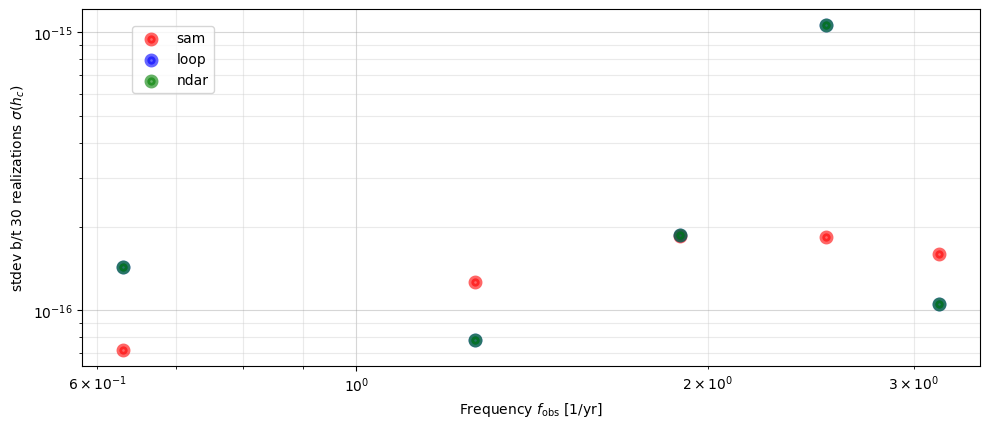

In [ ]:
# Plot the stdevs
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel=r'stdev b/t 30 realizations $\sigma(h_c)$', figsize=[10,4.5])

xx = fobs * YR

# # plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
# yy = 1e-15 * np.power(xx, -2.0/3.0)
# ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot single realizations
ax.scatter(xx, std_sam, lw=4.0, alpha=0.6, color='red', 
        label = 'sam')
ax.scatter(xx, std_loop, lw=4.0, alpha=0.6, color='blue', 
        label = 'loop')
ax.scatter(xx, std_loop, lw=4.0, alpha=0.6, color='green', 
        label = 'ndar')


legend_gwb = ax.legend(bbox_to_anchor=(.13,.92), bbox_transform=fig.transFigure, loc='upper left')
fig.tight_layout()

### Compare IQR

In [ ]:
# applying to my data
Q75_sam, Q25_sam = np.percentile(hc_sam30_sum, [75 ,25], axis=1)
IQR_sam = Q75_sam-Q25_sam
Q75_loop, Q25_loop = np.percentile(hc_loop30_sum, [75 ,25], axis=1)
IQR_loop = Q75_loop-Q25_loop
Q75_ndar, Q25_ndar = np.percentile(hc_ndar30_sum, [75 ,25], axis=1)
IQR_ndar = Q75_ndar-Q25_ndar
print(np.max(np.abs(IQR_loop-IQR_sam)))
print(np.max(np.abs(IQR_loop/IQR_sam)))
print(np.min(np.abs(IQR_loop/IQR_sam)))

print(np.max(np.abs(IQR_ndar-IQR_sam)))
print(np.max(np.abs(IQR_ndar/IQR_sam)))
print(np.min(np.abs(IQR_ndar/IQR_sam)))
print(IQR_loop.shape)

8.322358865498086e-17
1.8608673265831912
0.5753028704923415
9.565647944796387e-17
1.1148094690248385
0.498845696630464
(5,)


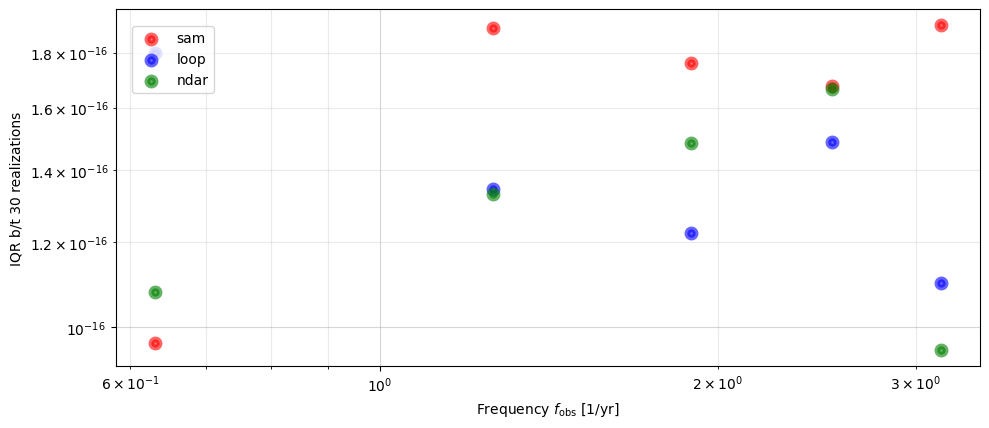

In [ ]:
# Plot the IQRs
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel=r'IQR b/t 30 realizations', figsize=[10,4.5])

xx = fobs * YR

# # plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
# yy = 1e-15 * np.power(xx, -2.0/3.0)
# ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot single realizations
ax.scatter(xx, IQR_sam, lw=4.0, alpha=0.6, color='red', 
        label = 'sam')
ax.scatter(xx, IQR_loop, lw=4.0, alpha=0.6, color='blue', 
        label = 'loop')
ax.scatter(xx, IQR_ndar, lw=4.0, alpha=0.6, color='green', 
        label = 'ndar')


legend_gwb = ax.legend(bbox_to_anchor=(.13,.92), bbox_transform=fig.transFigure, loc='upper left')
fig.tight_layout()

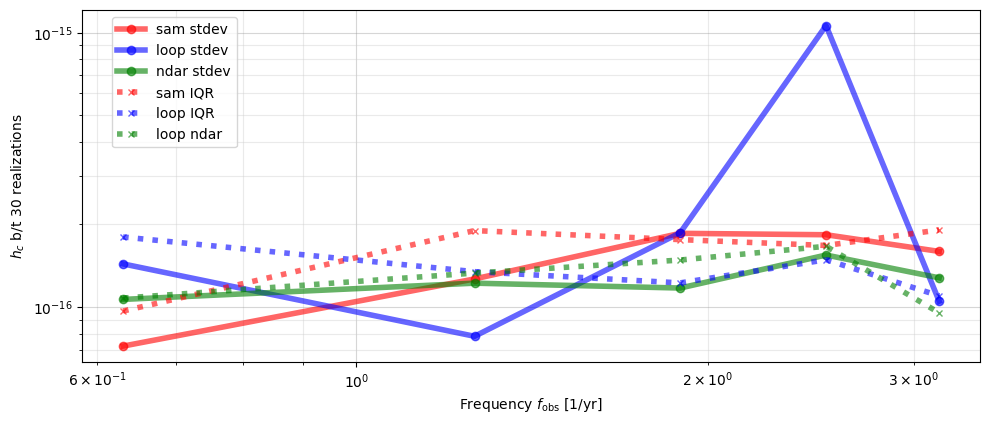

In [ ]:
# IQR and Stdev 
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel=r'$h_c$ b/t 30 realizations', figsize=[10,4.5])

xx = fobs * YR

# # plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
# yy = 1e-15 * np.power(xx, -2.0/3.0)
# ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')


ax.plot(xx, std_sam, lw=4.0, alpha=0.6, color='red', 
        label = 'sam stdev', marker='o', linestyle = 'solid')
ax.plot(xx, std_loop, lw=4.0, alpha=0.6, color='blue', 
        label = 'loop stdev', marker='o', linestyle = 'solid')
ax.plot(xx, std_ndar, lw=4.0, alpha=0.6, color='green', 
        label = 'ndar stdev', marker='o', linestyle = 'solid')


ax.plot(xx, IQR_sam, lw=4.0, alpha=0.6, color='red', 
        label = 'sam IQR', marker = 'x', ms = 5, linestyle='dotted')
ax.plot(xx, IQR_loop, lw=4.0, alpha=0.6, color='blue', 
        label = 'loop IQR', marker = 'x', ms=5, linestyle = 'dotted')
ax.plot(xx, IQR_ndar, lw=4.0, alpha=0.6, color='green', 
        label = 'loop ndar', marker = 'x', ms=5, linestyle = 'dotted')

legend_gwb = ax.legend(bbox_to_anchor=(.11,.93), bbox_transform=fig.transFigure, loc='upper left')
fig.tight_layout()

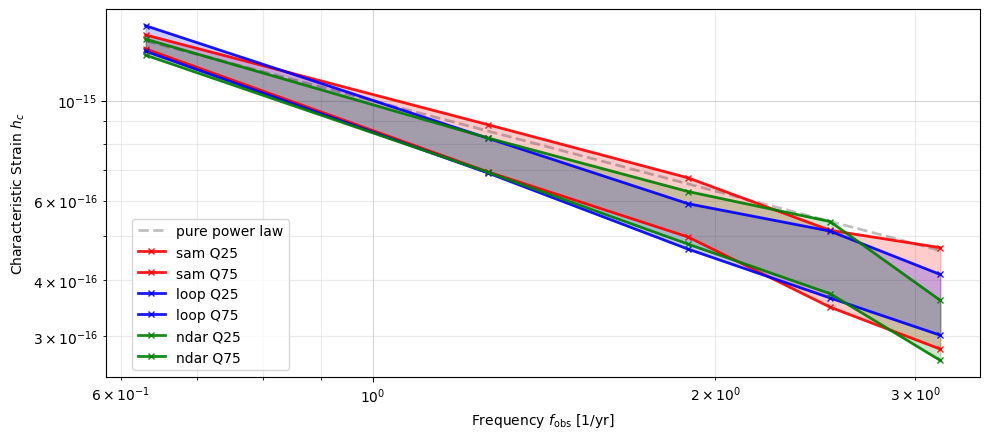

In [ ]:
# Plot percentiles
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])

xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot the model without sampling
# blue: my loop method
# red: the sam method
# ax.plot(xx, hc_loopF_sum, color='b', lw=4, ls = 'solid', label='unsampled GWB spectrum2 by loops')
# ax.plot(xx, hc_samF_sum, color='r', lw=3, ls = 'dashed', label='unsampled GWB spectrum2 by sam')

# plot just 25th and 75th percentile
ax.plot(xx, Q25_sam, lw=2.0, alpha=.9, color='red', 
        label = 'sam Q25', marker = 'x', ms=5, linestyle = 'solid')
ax.plot(xx, Q75_sam, lw=2.0, alpha=.9, color='red', 
        label = 'sam Q75', marker = 'x', ms=5, linestyle = 'solid')
ax.fill_between(xx, Q25_sam, Q75_sam, alpha=0.2, color='red')

ax.plot(xx, Q25_loop, lw=2.0, alpha=.9, color='blue', 
        label = 'loop Q25', marker = 'x', ms=5, linestyle = 'solid')
ax.plot(xx, Q75_loop, lw=2.0, alpha=.9, color='blue', 
        label = 'loop Q75', marker = 'x', ms=5, linestyle = 'solid')
ax.fill_between(xx, Q25_loop, Q75_loop, alpha=0.2, color='blue')

ax.plot(xx, Q25_ndar, lw=2.0, alpha=.9, color='green', 
        label = 'ndar Q25', marker = 'x', ms=5, linestyle = 'solid')
ax.plot(xx, Q75_ndar, lw=2.0, alpha=.9, color='green', 
        label = 'ndar Q75', marker = 'x', ms=5, linestyle = 'solid')
ax.fill_between(xx, Q25_ndar, Q75_ndar, alpha=0.2, color='green')

legend_gwb = ax.legend(bbox_to_anchor=(.13,.15), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()

## 3.3 Check impact of strain rounding

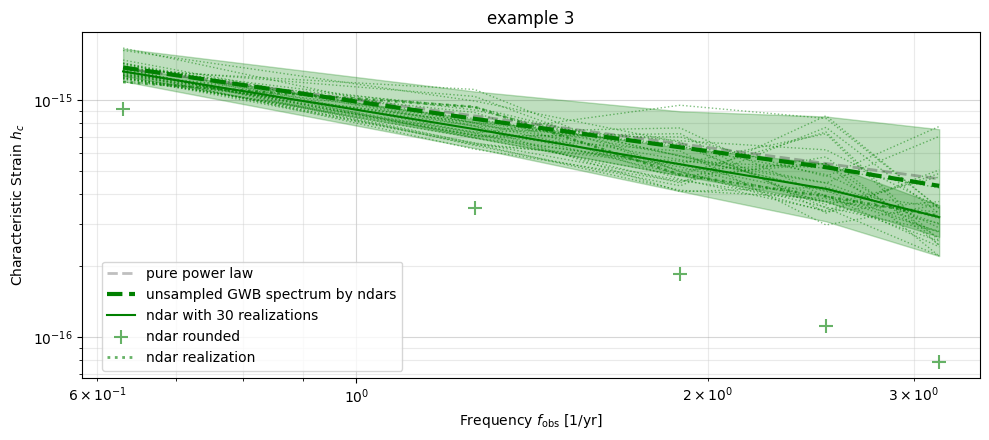

In [ ]:
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])
ax.set_title('example 3')

xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot the model without sampling
ax.plot(xx, hc_ndarF_sum, color='g', lw=3, ls = 'dashed', label='unsampled GWB spectrum by ndars')

# plot the model with Poisson sampling
add_sampleGWB_to_plot(fig, ax, hc_ndar30_sum, LABEL='ndar with 30 realizations', COLOR='g')

# plot rounded numbers
ax.scatter(xx, hc_ndarR_sum, marker='+', s=100, alpha=.6, color='g',
        label = 'ndar rounded')


# plot single realizations
ax.plot(xx, hc_ndar30_sum[:, 0], lw=2.0, alpha=0.6, color='green', linestyle = 'dotted',
        label = 'ndar realization')

legend_gwb = ax.legend(bbox_to_anchor=(.1,.15), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()

[9.28908006e-01 5.14916233e-01 9.44543381e-01 ... 1.69356953e-06
 5.87355789e-07 3.25585557e-07]
19641
69120
0.10580224816326773 0.005356720127448661


Text(0.5, 1.0, 'bin numbers rounded to 0')

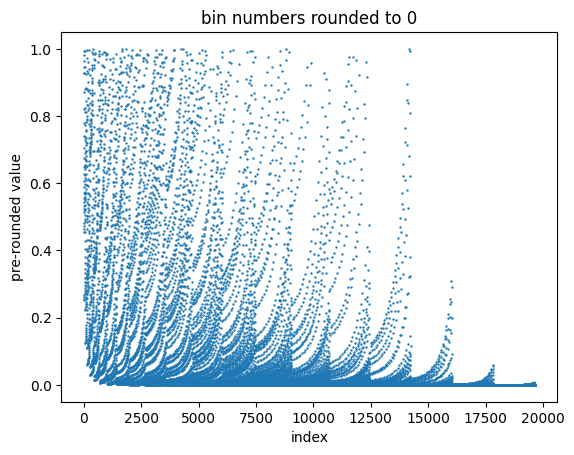

In [ ]:
roundtozero = number[((number>0) & (number<1))]
print(roundtozero)
print(roundtozero.size)
print(number.size)
print(np.average(roundtozero),
      np.median(roundtozero))
xvals = np.arange(0,len(roundtozero))
plt.scatter(xvals, number[((number>0) & (number<1))], s=.5)
plt.ylabel('pre-rounded value')
plt.xlabel('index')
plt.title('bin numbers rounded to 0')

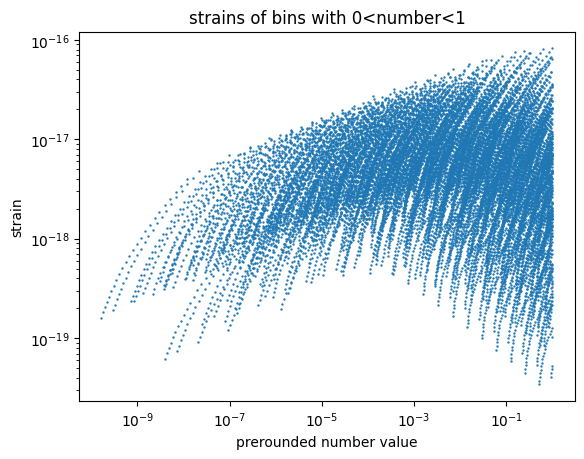

In [ ]:
roundedstrains = hc_loopF[((number>0) & (number<1))]
plt.title('strains of bins with 0<number<1')
plt.scatter(roundtozero, roundedstrains,  s=.5)
plt.xlabel('prerounded number value')
plt.ylabel('strain')
plt.yscale('log')
plt.xscale('log')

In [ ]:
plt.scatter(number[number>0], hc_loopF[((number>0))], s=.5)
plt.title('strain of bins with number>0, example 3')
plt.xlabel('number value')
plt.ylabel('strain')
plt.xscale('log')
plt.yscale('log')
plt.axvline(1, color='red', label='number=1')
plt.legend()

NameError: name 'hc_loopF' is not defined

##### Number dependence on parameters

In [ ]:
print(edges[0].shape)
print(number.shape)
# masses are first index of number
print(hc_loopF.shape)
mt = kale.utils.midpoints(edges[0]) #: total mass
mr = kale.utils.midpoints(edges[1]) #: mass ratio
rz = kale.utils.midpoints(edges[2]) #: redshift

ones = np.ones(number.shape)
masses = (mt[:,np.newaxis,np.newaxis,np.newaxis]*ones).flatten()
ratios = (mr[np.newaxis,:,np.newaxis,np.newaxis]*ones).flatten()
shifts = (rz[np.newaxis,np.newaxis,:,np.newaxis]*ones).flatten()
strains = hc_loopF.flatten()

(25,)
(24, 24, 24, 5)
(24, 24, 24, 5)


In [ ]:
# Testing my flattening of arrays and correlating the right bin parameters to strains

x = np.array([[[1,2,3],[10,20,30]], [[4,5,6],[40,50,60]], [[7,8,9],[70,80,90]], [[10,11,12],[100,110,120]]])
y = np.array([1,10])
ones = np.ones(x.shape)
flatx = x.flatten()
print(flatx)
print((y[:,np.newaxis]*ones).flatten())
z = np.array([1,4,7,10])
print((z[:,np.newaxis, np.newaxis]*ones).flatten())
print(x.flatten())

fourd = np.array([[[[1],[2],[3]], [[11],[22],[33]]], [[[4],[5],[6]], [[44],[55],[66]]],
                  [[[10],[20],[30]], [[110],[220],[330]]], [[[40],[50],[60]], [[440],[550],[660]]]])
fourdones = np.ones(fourd.shape)
m = np.array([1,4,10,40])
q = np.array([1, 11])
z = np.array([1, 2, 3])
print(fourd.shape)
print(m.shape)
print(q.shape)
print(z.shape)
print(fourd.flatten())
print((m[:,np.newaxis,np.newaxis,np.newaxis]*fourdones).flatten())
print((q[np.newaxis,:, np.newaxis,np.newaxis]*fourdones).flatten())
print((z[np.newaxis,np.newaxis,np.newaxis,:]*ones).flatten())

[  1   2   3  10  20  30   4   5   6  40  50  60   7   8   9  70  80  90
  10  11  12 100 110 120]
[ 1.  1.  1. 10. 10. 10.  1.  1.  1. 10. 10. 10.  1.  1.  1. 10. 10. 10.
  1.  1.  1. 10. 10. 10.]
[ 1.  1.  1.  1.  1.  1.  4.  4.  4.  4.  4.  4.  7.  7.  7.  7.  7.  7.
 10. 10. 10. 10. 10. 10.]
[  1   2   3  10  20  30   4   5   6  40  50  60   7   8   9  70  80  90
  10  11  12 100 110 120]
(4, 2, 3, 1)
(4,)
(2,)
(3,)
[  1   2   3  11  22  33   4   5   6  44  55  66  10  20  30 110 220 330
  40  50  60 440 550 660]
[ 1.  1.  1.  1.  1.  1.  4.  4.  4.  4.  4.  4. 10. 10. 10. 10. 10. 10.
 40. 40. 40. 40. 40. 40.]
[ 1.  1.  1. 11. 11. 11.  1.  1.  1. 11. 11. 11.  1.  1.  1. 11. 11. 11.
  1.  1.  1. 11. 11. 11.]
[1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3.]


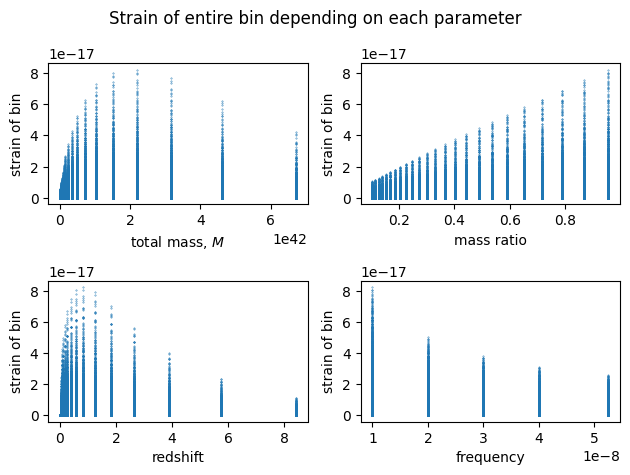

In [ ]:
mt = kale.utils.midpoints(edges[0]) #: total mass
mr = kale.utils.midpoints(edges[1]) #: mass ratio
rz = kale.utils.midpoints(edges[2]) #: redshift
fc = kale.utils.midpoints(edges[-1]) #: frequency bin centers

ones = np.ones(number.shape)
masses = (mt[:,np.newaxis,np.newaxis,np.newaxis]*ones)
ratios = (mr[np.newaxis,:,np.newaxis,np.newaxis]*ones)
shifts = (rz[np.newaxis,np.newaxis,:,np.newaxis]*ones)
ofreqs = (fc[np.newaxis,np.newaxis,np.newaxis,:]*ones)
strains = hc_loopF
numbers = number

fig, axs = plt.subplots(2,2)

fig.suptitle('Strain of entire bin depending on each parameter')
axs[0,0].scatter(masses, strains, s=.1)
axs[0,0].set_xlabel('total mass, $M$')
axs[0,0].set_ylabel('strain of bin')

axs[0,1].scatter(ratios, strains, s=.1)
axs[0,1].set_xlabel('mass ratio')
axs[0,1].set_ylabel('strain of bin')


axs[1,0].scatter(shifts, strains, s=.1)
axs[1,0].set_xlabel('redshift')
axs[1,0].set_ylabel('strain of bin')


axs[1,1].scatter(ofreqs, strains, s=.1)
axs[1,1].set_xlabel('frequency')
axs[1,1].set_ylabel('strain of bin')

fig.tight_layout()

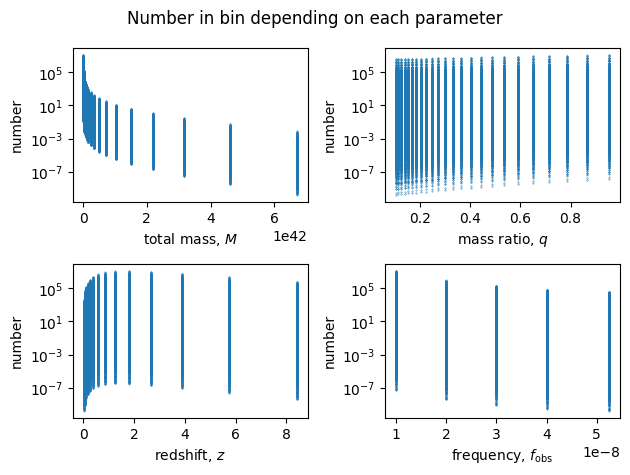

In [ ]:

fig, axs = plt.subplots(2,2)

fig.suptitle('Number in bin depending on each parameter')
axs[0,0].scatter(masses, numbers, s=.1)
axs[0,0].set_xlabel('total mass, $M$')
axs[0,0].set_ylabel('number')
axs[0,0].set_yscale('log')

axs[0,1].scatter(ratios, numbers, s=.1)
axs[0,1].set_xlabel('mass ratio, $q$')
axs[0,1].set_ylabel('number')
axs[0,1].set_yscale('log')

axs[1,0].scatter(shifts, numbers, s=.1)
axs[1,0].set_xlabel('redshift, $z$')
axs[1,0].set_ylabel('number')
axs[1,0].set_yscale('log')

axs[1,1].scatter(ofreqs, numbers, s=.1)
axs[1,1].set_xlabel('frequency, $f_\mathrm{obs}$')
axs[1,1].set_ylabel('number')
axs[1,1].set_yscale('log')

fig.tight_layout()

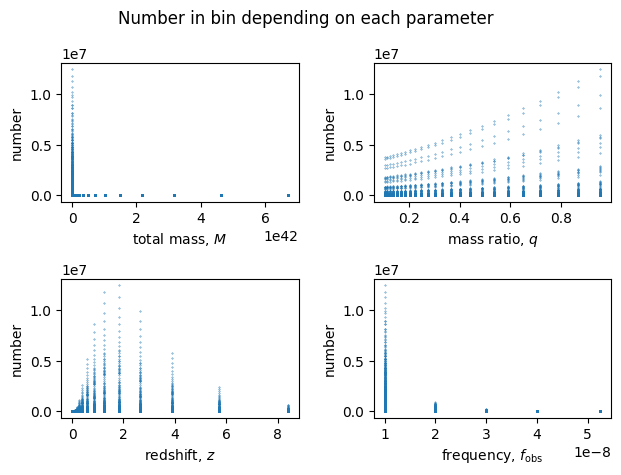

In [ ]:

fig, axs = plt.subplots(2,2)

fig.suptitle('Number in bin depending on each parameter')
axs[0,0].scatter(masses, numbers, s=.1)
axs[0,0].set_xlabel('total mass, $M$')
axs[0,0].set_ylabel('number')
# axs[0,0].set_yscale('log')

axs[0,1].scatter(ratios, numbers, s=.1)
axs[0,1].set_xlabel('mass ratio, $q$')
axs[0,1].set_ylabel('number')
# axs[0,1].set_yscale('log')

axs[1,0].scatter(shifts, numbers, s=.1)
axs[1,0].set_xlabel('redshift, $z$')
axs[1,0].set_ylabel('number')
# axs[1,0].set_yscale('log')

axs[1,1].scatter(ofreqs, numbers, s=.1)
axs[1,1].set_xlabel('frequency, $f_\mathrm{obs}$')
axs[1,1].set_ylabel('number')
# axs[1,1].set_yscale('log')

fig.tight_layout()

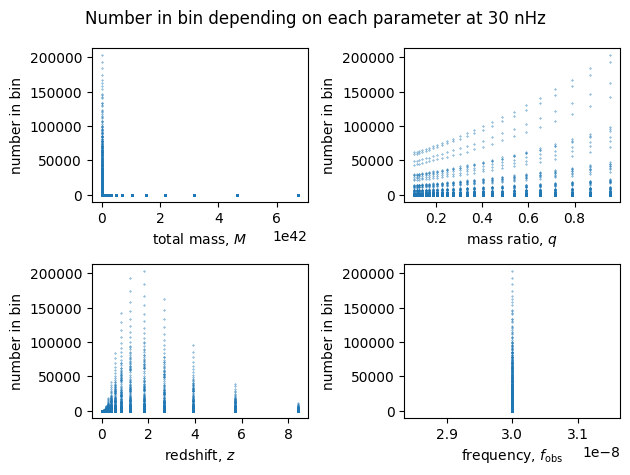

In [ ]:
masses_grid = (mt[:,np.newaxis,np.newaxis,np.newaxis]*ones)
ratios_grid = (mr[np.newaxis,:,np.newaxis,np.newaxis]*ones)
shifts_grid = (rz[np.newaxis,np.newaxis,:,np.newaxis]*ones)
ofreqs_grid = (fc[np.newaxis,np.newaxis,np.newaxis,:]*ones)
strains_grid = hc_loopF
numbers_grid = number

fig, axs = plt.subplots(2,2)

fig.suptitle('Number in bin depending on each parameter at %d nHz' % (ofreqs_grid[0,0,0,2]*10**9))
axs[0,0].scatter(masses[:,:,:,2], numbers[:,:,:,2], s=.1)
axs[0,0].set_xlabel('total mass, $M$')
axs[0,0].set_ylabel('number in bin')

axs[0,1].scatter(ratios[:,:,:,2], numbers[:,:,:,2], s=.1)
axs[0,1].set_xlabel('mass ratio, $q$')
axs[0,1].set_ylabel('number in bin')


axs[1,0].scatter(shifts[:,:,:,2], numbers[:,:,:,2], s=.1)
axs[1,0].set_xlabel('redshift, $z$')
axs[1,0].set_ylabel('number in bin')


axs[1,1].scatter(ofreqs[:,:,:,2], numbers[:,:,:,2], s=.1)
axs[1,1].set_xlabel('frequency, $f_\mathrm{obs}$')
axs[1,1].set_ylabel('number in bin')

fig.tight_layout()

1


NameError: name 'exname' is not defined

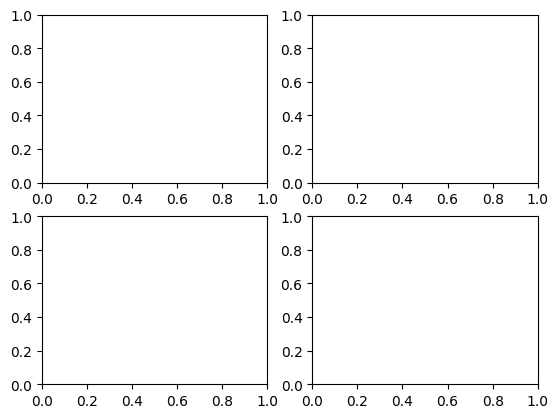

In [25]:
fig, axs = plt.subplots(2,2)
mid = int(np.min([len(edges[0]), len(edges[1]), len(edges[2])])*2/3)
fmid = int(len(edges[-1])*2/3)
print(mid)
fig.suptitle('Number vs Mass with varying other params, '+exname)

axs[0,0].set_title('constant q,z,f')
axs[0,0].scatter(masses[:,mid,mid,fmid], numbers[:,mid,mid,fmid], s=.1)
axs[0,0].set_xlabel('total mass, $M$')
axs[0,0].set_ylabel('number in bin')

axs[0,1].set_title('constant q,f')
axs[0,1].scatter(masses[:,:,mid,fmid], numbers[:,:,mid,fmid], s=.1)
axs[0,1].set_xlabel('total mass, $M$')
axs[0,1].set_ylabel('strain of bin')

axs[1,0].set_title('constant z,f')
axs[1,0].scatter(masses[:,mid,:,fmid], numbers[:,mid,:,fmid], s=.1)
axs[1,0].set_xlabel('total mass, $M$')
axs[1,0].set_ylabel('strain of bin')

axs[1,1].set_title('none const')
axs[1,1].scatter(masses[...], numbers[...], s=.1)
axs[1,1].set_xlabel('total mass, $M$')
axs[1,1].set_ylabel('strain of bin')

fig.tight_layout()

# 4. Even More Complex Example - Casting 64bit


## 4.1 Calculate Strains
### Choose the frequency bins at which to calculate the GWB

In [ ]:
dur = 5.0*YR/3.1557600
cad = .2*YR/3.1557600
fobs = utils.nyquist_freqs(dur,cad)
fobs_edges = utils.nyquist_freqs_edges(dur,cad)
print(f"Number of frequency bins: {fobs.size-1}")
print(f"  between [{fobs[0]*YR:.2f}, {fobs[-1]*YR:.2f}] 1/yr")
print(f"          [{fobs[0]*1e9:.2f}, {fobs[-1]*1e9:.2f}] nHz")

Number of frequency bins: 11
  between [0.63, 7.57] 1/yr
          [20.00, 240.00] nHz


### Build Semi-Analytic-Model with super simple parameters 

In [ ]:
mtot=(1.0e6*MSOL/1.988409870698051, (4.0e11*MSOL).astype(np.float64), 25)
mrat=(1e-1, 1.0, 25)
redz=(1e-3, 10.0, 25)
sam = holo.sam.Semi_Analytic_Model(mtot, mrat, redz)
print('edges:', sam.edges)

edges: [array([1.00000000e+39, 1.76139562e+39, 3.10251454e+39, 5.46475552e+39,
       9.62559645e+39, 1.69544835e+40, 2.98635529e+40, 5.26015314e+40,
       9.26521071e+40, 1.63197016e+41, 2.87454509e+41, 5.06321114e+41,
       8.91831794e+41, 1.57086862e+42, 2.76692110e+42, 4.87364272e+42,
       8.58441295e+42, 1.51205474e+43, 2.66332660e+43, 4.69117181e+43,
       8.26300949e+43, 1.45544287e+44, 2.56361071e+44, 4.51553267e+44,
       7.95363948e+44]), array([0.1       , 0.11006942, 0.12115277, 0.13335214, 0.14677993,
       0.16155981, 0.17782794, 0.19573418, 0.21544347, 0.23713737,
       0.26101572, 0.28729848, 0.31622777, 0.34807006, 0.38311868,
       0.4216965 , 0.46415888, 0.51089698, 0.56234133, 0.61896582,
       0.68129207, 0.74989421, 0.82540419, 0.90851758, 1.        ]), array([1.00000000e-03, 1.46779927e-03, 2.15443469e-03, 3.16227766e-03,
       4.64158883e-03, 6.81292069e-03, 1.00000000e-02, 1.46779927e-02,
       2.15443469e-02, 3.16227766e-02, 4.64158883e-02, 6.81292

### Get SAM edges and numbers as in sam.gwb()

In [ ]:
# get observed orbital frequency bin edges and centers 
# from observed GW frequency bin edges
# f_orb = f_GW/2
fobs_orb_edges = fobs_edges / 2.0
fobs_orb_cents = kale.utils.midpoints(fobs_edges) / 2.0

# dynamic_binary_number
# gets differential number of binaries per bin-vol per log freq interval
edges, dnum = sam.dynamic_binary_number(holo.hardening.Hard_GW, fobs_orb=fobs_orb_cents)
edges[-1] = fobs_orb_edges

# integrate (multiply by bin volume) within each bin
number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
number = number * np.diff(np.log(fobs_edges))

### Calculate strain by three methods
1) Using gravwaves._gws_from_number_grid_integrated()
2) Using gws_by_loops() (above)
3) Using gws_by_ndars() (above)

In [ ]:
# 1. Get GWB spectrum using gravwaves._gws_from_number_grid_integrated()

# without sampling
hc_samF = holo.gravwaves._gws_from_number_grid_integrated(edges, number, realize=False, sum=False) 
hc_samF_sum = holo.gravwaves._gws_from_number_grid_integrated(edges, number, realize=False, sum=True)

# for many realizations
hc_sam30 = holo.sam.gravwaves._gws_from_number_grid_integrated(edges, number, realize=30, sum=False)
hc_sam30_sum = holo.sam.gravwaves._gws_from_number_grid_integrated(edges, number, realize=30, sum=True)

In [ ]:
# 2. Get GWB spectrum using gws_by_loops()

# without sampling
hc_loopF = gws_by_loops(edges, number, realize=False, sum=False)  
hc_loopF_sum = gws_by_loops(edges, number, realize=False, sum=True)   
 
# for many realizations
hc_loop30 = gws_by_loops(edges, number, realize=30, sum=False)  
hc_loop30_sum = gws_by_loops(edges, number, realize=30, sum=True)   

# without sampling, but discretized
hc_loopR = gws_by_loops(edges, number, realize=False, round=True, sum=False)  
hc_loopR_sum = gws_by_loops(edges, number, realize=False, round=True, sum=True)  

In [ ]:
# 3. Get GWB spectrum using gws_by_ndars()

# without sampling
hc_ndarF = gws_by_ndars(edges, number, realize=False, sum=False)  
hc_ndarF_sum = gws_by_ndars(edges, number, realize=False, sum=True)   
 
# for many realizations
hc_ndar30 = gws_by_ndars(edges, number, realize=30, sum=False)  
hc_ndar30_sum = gws_by_ndars(edges, number, realize=30, sum=True)  

# without sampling, but discretized
hc_ndarR = gws_by_ndars(edges, number, realize=False, round=True, sum=False)  
hc_ndarR_sum = gws_by_ndars(edges, number, realize=False, round=True, sum=True) 

## 4.2 Compare Results

### Check unsampled strain distributions
Should match to machine precision

In [ ]:
assert (hc_loopF == hc_samF).all, "Loop strains don't match SAM."
assert (hc_loopF_sum == hc_samF_sum).all, "Loop strain sums don't match SAM."
assert (hc_ndarF == hc_samF).all, "Ndar strains don't match SAM."
assert (hc_ndarF_sum == hc_samF_sum).all, "Ndar strain sums don't match SAM."
assert (hc_ndarR == hc_loopR).all, "Rounded ndar strains don't match loop."
assert (hc_ndarR_sum == hc_loopR_sum).all, "Rounded ndar strain sums don't match loop."
assert (hc_ndarR != hc_ndarF).all, "Rounded ndar strains matchs non-rounded ndar. \
    They shouldn't."
assert (hc_ndarR_sum != hc_loopF_sum).all, "Rounded ndar strain sums match non-rounded \
    ndar. They shouldn't"

NameError: name 'hc_loopF' is not defined

In [ ]:
# strain for each M, q, z, and f bin
print(hc_samF == hc_ndarF)
# should be exact same
# print('hc by sam:\n', hc_samF)
# print('hc by loop:\n', hc_loopF)

[[[[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  ...

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  Tru

In [ ]:
print(np.all(hc_loopR == hc_ndarR))
print(hc_loopR[np.where(hc_loopR != hc_ndarR)] 
      - hc_ndarR[np.where(hc_loopR != hc_ndarR)])
print(hc_loopR[np.where(hc_loopR != hc_ndarR)] 
      / hc_ndarR[np.where(hc_loopR != hc_ndarR)])


False
[ 1.20370622e-35  4.81482486e-35  1.20370622e-35  2.40741243e-35
  6.01853108e-36  2.40741243e-35 -2.40741243e-35  4.81482486e-35
  3.00926554e-36  6.01853108e-36 -2.40741243e-35  4.81482486e-35
 -2.40741243e-35 -4.81482486e-35 -2.40741243e-35  2.40741243e-35
 -4.81482486e-35  4.81482486e-35  4.81482486e-35  4.81482486e-35
  9.62964972e-35  2.40741243e-35 -1.92592994e-34  9.62964972e-35
 -2.40741243e-35 -1.92592994e-34 -1.92592994e-34  9.62964972e-35
  9.62964972e-35  9.62964972e-35 -1.92592994e-34 -1.92592994e-34
  1.92592994e-34 -3.08148791e-33]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Plot multiple realizations vs frequency

In [ ]:
def add_sampleGWB_to_plot(fig, ax, PLOT_GWB, LABEL, COLOR='b'):
    nsamp = PLOT_GWB.shape[1]
    ax.plot(xx, np.median(PLOT_GWB, axis=1), color=COLOR, label=LABEL)
    # plot contours at 50% and 98% confidence intervals
    for pp in [50, 98]:
        percs = pp / 2
        percs = [50 - percs, 50 + percs]
        ax.fill_between(xx, *np.percentile(PLOT_GWB, percs, axis=-1), alpha=0.25, color=COLOR)
    # Plot `nsamp` random spectra 
    
    idx = np.random.choice(PLOT_GWB.shape[1], nsamp, replace=False)
    ax.plot(xx, PLOT_GWB[:, idx], lw=1.0, alpha=0.5, color=COLOR, linestyle = 'dotted')

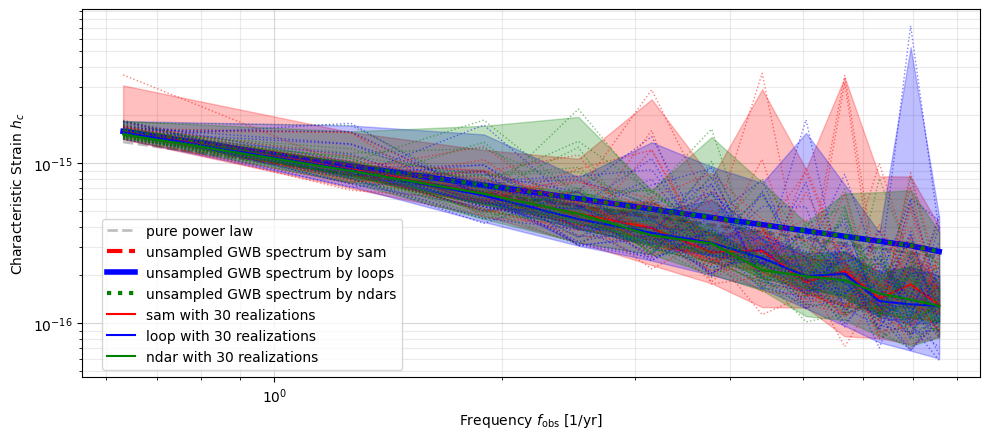

In [ ]:
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])

xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot the model without sampling
# blue: my loop method
# green: my ndar method
# red: the sam method
ax.plot(xx, hc_samF_sum, color='r', lw=3, ls = 'dashed', label='unsampled GWB spectrum by sam')
ax.plot(xx, hc_loopF_sum, color='b', lw=4, ls = 'solid', label='unsampled GWB spectrum by loops')
ax.plot(xx, hc_ndarF_sum, color='g', lw=3, ls = 'dotted', label='unsampled GWB spectrum by ndars')

# plot the model with Poisson sampling
add_sampleGWB_to_plot(fig, ax, hc_sam30_sum, LABEL='sam with 30 realizations', COLOR='r')
add_sampleGWB_to_plot(fig, ax, hc_loop30_sum, LABEL='loop with 30 realizations', COLOR='b')
add_sampleGWB_to_plot(fig, ax, hc_ndar30_sum, LABEL='ndar with 30 realizations', COLOR='g')

# plot single realizations
# ax.plot(xx, hc_loop10_sum[:, 0], lw=4.0, alpha=0.6, color='green', linestyle = 'dotted',
#         label = 'loop realization')
# ax.plot(xx, hc_sam10_sum[:, 0], lw=4.0, alpha=0.6, color='purple', linestyle = 'dotted',
#         label = 'sam realization')


legend_gwb = ax.legend(bbox_to_anchor=(.1,.15), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()

### Rounded number strains

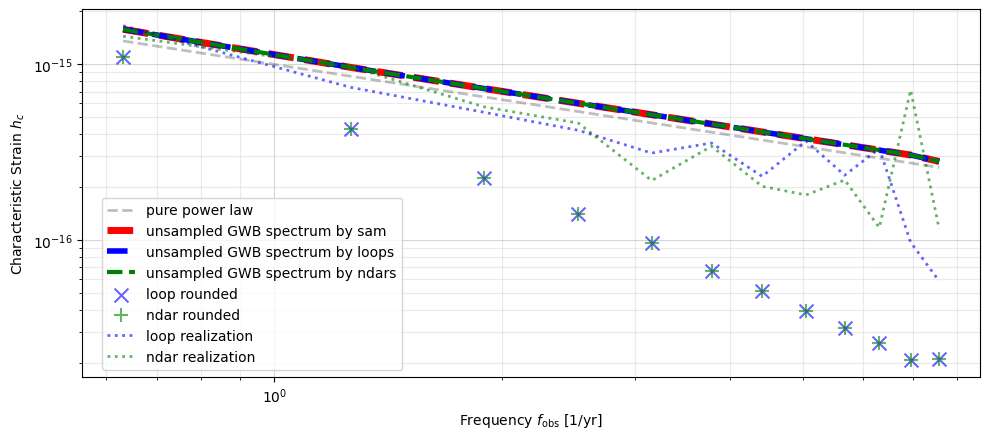

In [ ]:
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])

xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot the model without sampling
# blue: my loop method
# green: my ndar method
# red: the sam method
ax.plot(xx, hc_samF_sum, color='r', lw=5, ls = 'dashed', label='unsampled GWB spectrum by sam')
ax.plot(xx, hc_loopF_sum, color='b', lw=4, ls = 'dashed', label='unsampled GWB spectrum by loops')
ax.plot(xx, hc_ndarF_sum, color='g', lw=3, ls = 'dashed', label='unsampled GWB spectrum by ndars')

# plot the model with Poisson sampling
# add_sampleGWB_to_plot(fig, ax, hc_sam30_sum, LABEL='sam with 30 realizations', COLOR='r')
# add_sampleGWB_to_plot(fig, ax, hc_loop30_sum, LABEL='loop with 30 realizations', COLOR='b')
# add_sampleGWB_to_plot(fig, ax, hc_ndar30_sum, LABEL='ndar with 30 realizations', COLOR='g')

# plot rounded numbers
# ax.plot(xx, hc_loopR_sum, lw=4, color='b', linestyle = 'dotted',
#         label = 'loop rounded')
# ax.plot(xx, hc_ndarR_sum, lw=3, color='g', linestyle = 'dotted',
#         label = 'ndar rounded')
ax.scatter(xx, hc_loopR_sum, marker='x', s = 100, alpha=.6, color='b', 
        label = 'loop rounded')
ax.scatter(xx, hc_ndarR_sum, marker='+', s=100, alpha=.6, color='g',
        label = 'ndar rounded')


# plot single realizations
ax.plot(xx, hc_loop30_sum[:, 0], lw=2.0, alpha=0.6, color='blue', linestyle = 'dotted',
        label = 'loop realization')
ax.plot(xx, hc_sam30_sum[:, 0], lw=2.0, alpha=0.6, color='green', linestyle = 'dotted',
        label = 'ndar realization')

legend_gwb = ax.legend(bbox_to_anchor=(.1,.15), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()

### Compare realization standard deviations

In [ ]:
std_sam = np.std(hc_sam30_sum, axis=1)
std_loop = np.std(hc_loop30_sum, axis=1)
std_ndar = np.std(hc_ndar30_sum, axis=1)
print(np.max(np.abs(std_ndar-std_sam)))
print(np.max(np.abs(std_ndar/std_sam)))
print(std_ndar.shape)

6.450359031756622e-16
2.077495743021746
(12,)


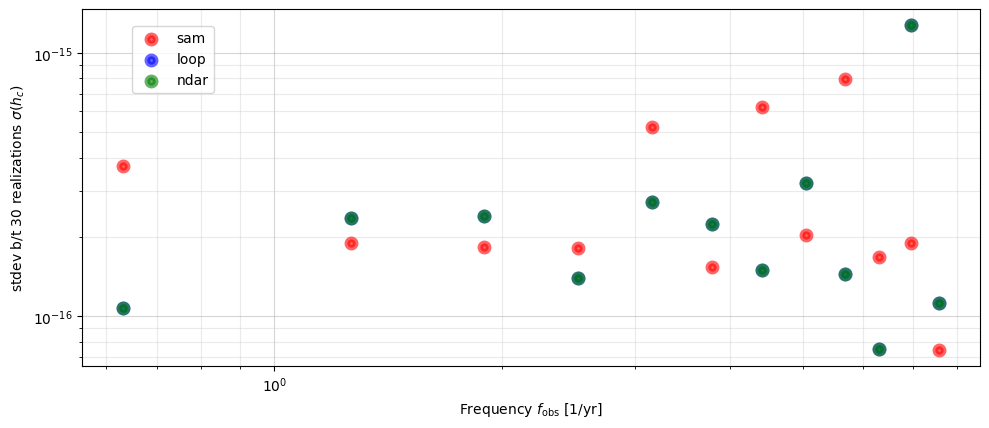

In [ ]:
# Plot the stdevs
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel=r'stdev b/t 30 realizations $\sigma(h_c)$', figsize=[10,4.5])

xx = fobs * YR

# # plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
# yy = 1e-15 * np.power(xx, -2.0/3.0)
# ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot single realizations
ax.scatter(xx, std_sam, lw=4.0, alpha=0.6, color='red', 
        label = 'sam')
ax.scatter(xx, std_loop, lw=4.0, alpha=0.6, color='blue', 
        label = 'loop')
ax.scatter(xx, std_loop, lw=4.0, alpha=0.6, color='green', 
        label = 'ndar')


legend_gwb = ax.legend(bbox_to_anchor=(.13,.92), bbox_transform=fig.transFigure, loc='upper left')
fig.tight_layout()

### Compare IQR

In [ ]:
# applying to my data
Q75_sam, Q25_sam = np.percentile(hc_sam30_sum, [75 ,25], axis=1)
IQR_sam = Q75_sam-Q25_sam
Q75_loop, Q25_loop = np.percentile(hc_loop30_sum, [75 ,25], axis=1)
IQR_loop = Q75_loop-Q25_loop
Q75_ndar, Q25_ndar = np.percentile(hc_ndar30_sum, [75 ,25], axis=1)
IQR_ndar = Q75_ndar-Q25_ndar
print(np.max(np.abs(IQR_loop-IQR_sam)))
print(np.max(np.abs(IQR_loop/IQR_sam)))
print(np.min(np.abs(IQR_loop/IQR_sam)))

print(np.max(np.abs(IQR_ndar-IQR_sam)))
print(np.max(np.abs(IQR_ndar/IQR_sam)))
print(np.min(np.abs(IQR_ndar/IQR_sam)))
print(IQR_loop.shape)

2.0442442811983845e-16
2.66270203118748
0.6128290909144305
9.451086767913919e-17
1.5100929327622736
0.4389525767050593
(12,)


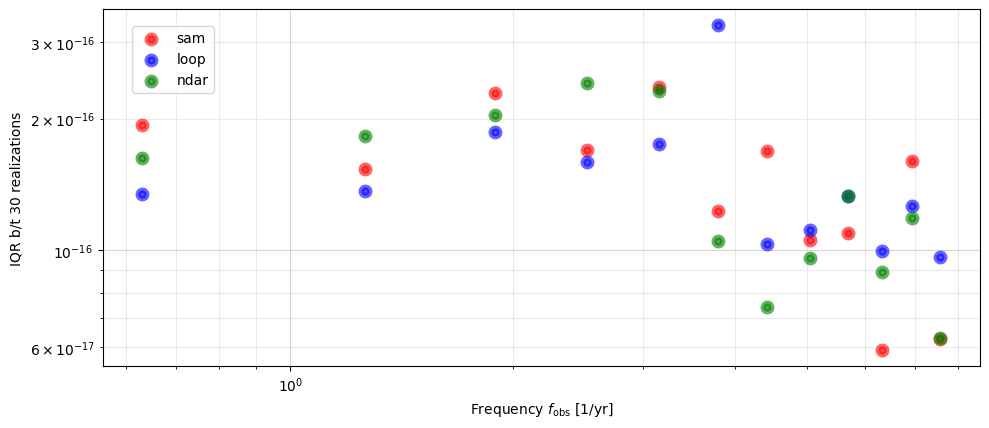

In [ ]:
# Plot the IQRs
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel=r'IQR b/t 30 realizations', figsize=[10,4.5])

xx = fobs * YR

# # plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
# yy = 1e-15 * np.power(xx, -2.0/3.0)
# ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot single realizations
ax.scatter(xx, IQR_sam, lw=4.0, alpha=0.6, color='red', 
        label = 'sam')
ax.scatter(xx, IQR_loop, lw=4.0, alpha=0.6, color='blue', 
        label = 'loop')
ax.scatter(xx, IQR_ndar, lw=4.0, alpha=0.6, color='green', 
        label = 'ndar')


legend_gwb = ax.legend(bbox_to_anchor=(.13,.92), bbox_transform=fig.transFigure, loc='upper left')
fig.tight_layout()

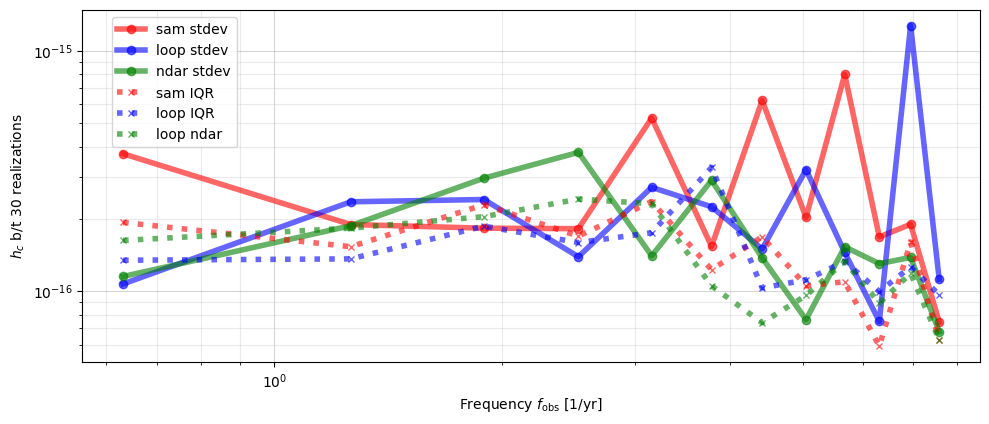

In [ ]:
# IQR and Stdev 
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel=r'$h_c$ b/t 30 realizations', figsize=[10,4.5])

xx = fobs * YR

# # plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
# yy = 1e-15 * np.power(xx, -2.0/3.0)
# ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')


ax.plot(xx, std_sam, lw=4.0, alpha=0.6, color='red', 
        label = 'sam stdev', marker='o', linestyle = 'solid')
ax.plot(xx, std_loop, lw=4.0, alpha=0.6, color='blue', 
        label = 'loop stdev', marker='o', linestyle = 'solid')
ax.plot(xx, std_ndar, lw=4.0, alpha=0.6, color='green', 
        label = 'ndar stdev', marker='o', linestyle = 'solid')


ax.plot(xx, IQR_sam, lw=4.0, alpha=0.6, color='red', 
        label = 'sam IQR', marker = 'x', ms = 5, linestyle='dotted')
ax.plot(xx, IQR_loop, lw=4.0, alpha=0.6, color='blue', 
        label = 'loop IQR', marker = 'x', ms=5, linestyle = 'dotted')
ax.plot(xx, IQR_ndar, lw=4.0, alpha=0.6, color='green', 
        label = 'loop ndar', marker = 'x', ms=5, linestyle = 'dotted')

legend_gwb = ax.legend(bbox_to_anchor=(.11,.93), bbox_transform=fig.transFigure, loc='upper left')
fig.tight_layout()

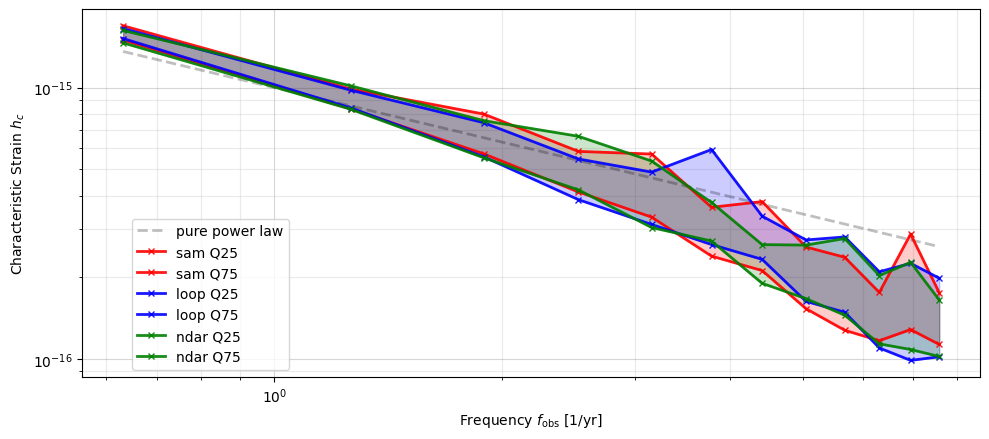

In [ ]:
# Plot percentiles
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])

xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot the model without sampling
# blue: my loop method
# red: the sam method
# ax.plot(xx, hc_loopF_sum, color='b', lw=4, ls = 'solid', label='unsampled GWB spectrum2 by loops')
# ax.plot(xx, hc_samF_sum, color='r', lw=3, ls = 'dashed', label='unsampled GWB spectrum2 by sam')

# plot just 25th and 75th percentile
ax.plot(xx, Q25_sam, lw=2.0, alpha=.9, color='red', 
        label = 'sam Q25', marker = 'x', ms=5, linestyle = 'solid')
ax.plot(xx, Q75_sam, lw=2.0, alpha=.9, color='red', 
        label = 'sam Q75', marker = 'x', ms=5, linestyle = 'solid')
ax.fill_between(xx, Q25_sam, Q75_sam, alpha=0.2, color='red')

ax.plot(xx, Q25_loop, lw=2.0, alpha=.9, color='blue', 
        label = 'loop Q25', marker = 'x', ms=5, linestyle = 'solid')
ax.plot(xx, Q75_loop, lw=2.0, alpha=.9, color='blue', 
        label = 'loop Q75', marker = 'x', ms=5, linestyle = 'solid')
ax.fill_between(xx, Q25_loop, Q75_loop, alpha=0.2, color='blue')

ax.plot(xx, Q25_ndar, lw=2.0, alpha=.9, color='green', 
        label = 'ndar Q25', marker = 'x', ms=5, linestyle = 'solid')
ax.plot(xx, Q75_ndar, lw=2.0, alpha=.9, color='green', 
        label = 'ndar Q75', marker = 'x', ms=5, linestyle = 'solid')
ax.fill_between(xx, Q25_ndar, Q75_ndar, alpha=0.2, color='green')

legend_gwb = ax.legend(bbox_to_anchor=(.13,.15), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()

## 4.3 Check impact of strain rounding

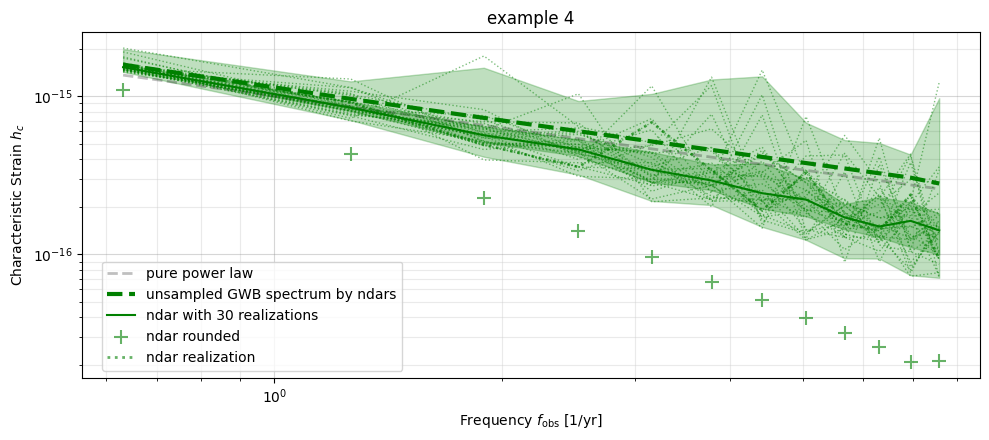

In [ ]:
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])
ax.set_title('example 4')

xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot the model without sampling
# blue: my loop method
# green: my ndar method
# red: the sam method
# ax.plot(xx, hc_samF_sum, color='r', lw=5, ls = 'dashed', label='unsampled GWB spectrum by sam')
# ax.plot(xx, hc_loopF_sum, color='b', lw=4, ls = 'dashed', label='unsampled GWB spectrum by loops')
ax.plot(xx, hc_ndarF_sum, color='g', lw=3, ls = 'dashed', label='unsampled GWB spectrum by ndars')

# plot the model with Poisson sampling
# add_sampleGWB_to_plot(fig, ax, hc_sam30_sum, LABEL='sam with 30 realizations', COLOR='r')
# add_sampleGWB_to_plot(fig, ax, hc_loop30_sum, LABEL='loop with 30 realizations', COLOR='b')
add_sampleGWB_to_plot(fig, ax, hc_ndar30_sum, LABEL='ndar with 30 realizations', COLOR='g')

# plot rounded numbers
# ax.plot(xx, hc_loopR_sum, lw=4, color='b', linestyle = 'dotted',
#         label = 'loop rounded')
# ax.plot(xx, hc_ndarR_sum, lw=3, color='g', linestyle = 'dotted',
#         label = 'ndar rounded')
# ax.scatter(xx, hc_loopR_sum, marker='x', s = 100, alpha=.6, color='b', 
#         label = 'loop rounded')
ax.scatter(xx, hc_ndarR_sum, marker='+', s=100, alpha=.6, color='g',
        label = 'ndar rounded')


# plot single realizations
# ax.plot(xx, hc_loop30_sum[:, 0], lw=2.0, alpha=0.6, color='blue', linestyle = 'dotted',
#         label = 'loop realization')
ax.plot(xx, hc_ndar30_sum[:, 0], lw=2.0, alpha=0.6, color='green', linestyle = 'dotted',
        label = 'ndar realization')

legend_gwb = ax.legend(bbox_to_anchor=(.1,.15), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()

[8.37142838e-001 5.43402051e-001 3.69197464e-001 ... 4.14404242e-131
 2.92138018e-131 3.66171251e-131]
73988
165888
0.04785603216355383 2.4554823089257744e-07


Text(0.5, 1.0, 'bin numbers rounded to 0')

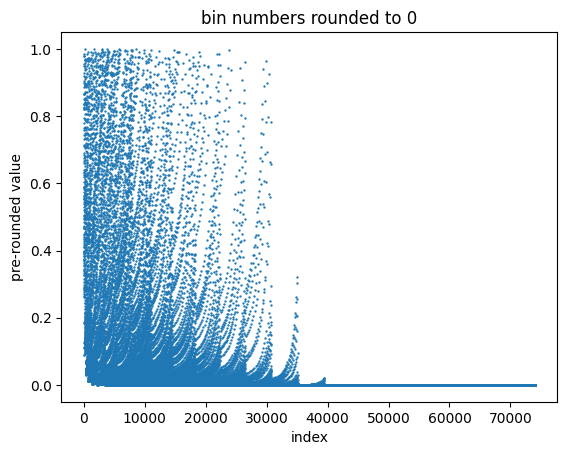

In [ ]:
roundtozero = number[((number>0) & (number<1))]
print(roundtozero)
print(roundtozero.size)
print(number.size)
print(np.average(roundtozero),
      np.median(roundtozero))
xvals = np.arange(0,len(roundtozero))
plt.scatter(xvals, number[((number>0) & (number<1))], s=.5)
plt.ylabel('pre-rounded value')
plt.xlabel('index')
plt.title('bin numbers rounded to 0')

In [ ]:
print(number.shape)
print(24*24*24*12)

(24, 24, 24, 12)
165888


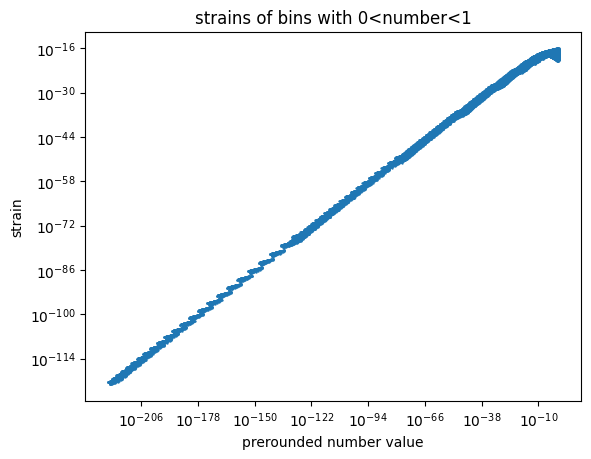

In [ ]:
roundedstrains = hc_ndarF[((number>0) & (number<1))]
plt.title('strains of bins with 0<number<1')
plt.scatter(roundtozero, roundedstrains,  s=.5)
plt.xlabel('prerounded number value')
plt.ylabel('strain')
plt.yscale('log')
plt.xscale('log')

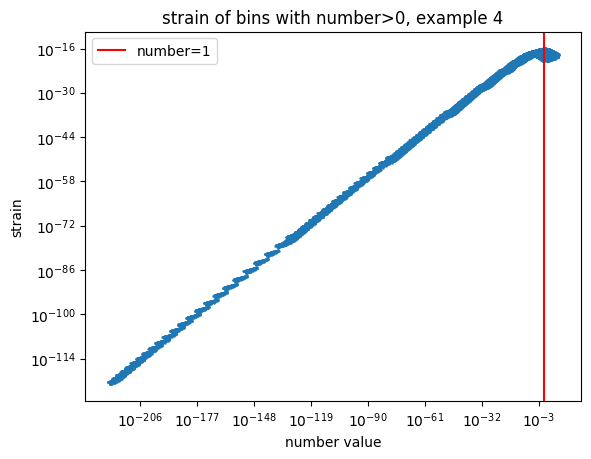

In [ ]:
plt.scatter(number[number>0], hc_ndarF[((number>0))], s=.5)
plt.title('strain of bins with number>0, example 4')
plt.xlabel('number value')
plt.ylabel('strain')
plt.xscale('log')
plt.yscale('log')
plt.axvline(1, color='red', label='number=1')
plt.legend()

##### Number dependence on parameters

In [ ]:
print(edges[0].shape)
print(number.shape)
# masses are first index of number
print(hc_loopF.shape)
mt = kale.utils.midpoints(edges[0]) #: total mass
mr = kale.utils.midpoints(edges[1]) #: mass ratio
rz = kale.utils.midpoints(edges[2]) #: redshift

ones = np.ones(number.shape)
masses = (mt[:,np.newaxis,np.newaxis,np.newaxis]*ones).flatten()
ratios = (mr[np.newaxis,:,np.newaxis,np.newaxis]*ones).flatten()
shifts = (rz[np.newaxis,np.newaxis,:,np.newaxis]*ones).flatten()
strains = hc_loopF.flatten()

(25,)
(24, 24, 24, 5)
(24, 24, 24, 5)


In [ ]:
# Testing my flattening of arrays and correlating the right bin parameters to strains

x = np.array([[[1,2,3],[10,20,30]], [[4,5,6],[40,50,60]], [[7,8,9],[70,80,90]], [[10,11,12],[100,110,120]]])
y = np.array([1,10])
ones = np.ones(x.shape)
flatx = x.flatten()
print(flatx)
print((y[:,np.newaxis]*ones).flatten())
z = np.array([1,4,7,10])
print((z[:,np.newaxis, np.newaxis]*ones).flatten())
print(x.flatten())

fourd = np.array([[[[1],[2],[3]], [[11],[22],[33]]], [[[4],[5],[6]], [[44],[55],[66]]],
                  [[[10],[20],[30]], [[110],[220],[330]]], [[[40],[50],[60]], [[440],[550],[660]]]])
fourdones = np.ones(fourd.shape)
m = np.array([1,4,10,40])
q = np.array([1, 11])
z = np.array([1, 2, 3])
print(fourd.shape)
print(m.shape)
print(q.shape)
print(z.shape)
print(fourd.flatten())
print((m[:,np.newaxis,np.newaxis,np.newaxis]*fourdones).flatten())
print((q[np.newaxis,:, np.newaxis,np.newaxis]*fourdones).flatten())
print((z[np.newaxis,np.newaxis,np.newaxis,:]*ones).flatten())

[  1   2   3  10  20  30   4   5   6  40  50  60   7   8   9  70  80  90
  10  11  12 100 110 120]
[ 1.  1.  1. 10. 10. 10.  1.  1.  1. 10. 10. 10.  1.  1.  1. 10. 10. 10.
  1.  1.  1. 10. 10. 10.]
[ 1.  1.  1.  1.  1.  1.  4.  4.  4.  4.  4.  4.  7.  7.  7.  7.  7.  7.
 10. 10. 10. 10. 10. 10.]
[  1   2   3  10  20  30   4   5   6  40  50  60   7   8   9  70  80  90
  10  11  12 100 110 120]
(4, 2, 3, 1)
(4,)
(2,)
(3,)
[  1   2   3  11  22  33   4   5   6  44  55  66  10  20  30 110 220 330
  40  50  60 440 550 660]
[ 1.  1.  1.  1.  1.  1.  4.  4.  4.  4.  4.  4. 10. 10. 10. 10. 10. 10.
 40. 40. 40. 40. 40. 40.]
[ 1.  1.  1. 11. 11. 11.  1.  1.  1. 11. 11. 11.  1.  1.  1. 11. 11. 11.
  1.  1.  1. 11. 11. 11.]
[1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3.]


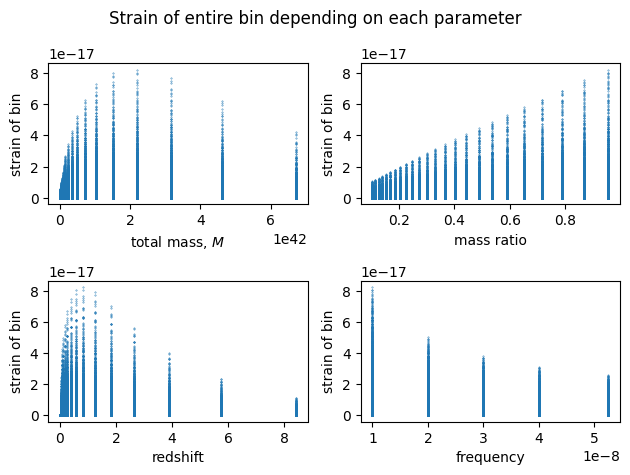

In [ ]:
mt = kale.utils.midpoints(edges[0]) #: total mass
mr = kale.utils.midpoints(edges[1]) #: mass ratio
rz = kale.utils.midpoints(edges[2]) #: redshift
fc = kale.utils.midpoints(edges[-1]) #: frequency bin centers

ones = np.ones(number.shape)
masses = (mt[:,np.newaxis,np.newaxis,np.newaxis]*ones)
ratios = (mr[np.newaxis,:,np.newaxis,np.newaxis]*ones)
shifts = (rz[np.newaxis,np.newaxis,:,np.newaxis]*ones)
ofreqs = (fc[np.newaxis,np.newaxis,np.newaxis,:]*ones)
strains = hc_loopF
numbers = number

fig, axs = plt.subplots(2,2)

fig.suptitle('Strain of entire bin depending on each parameter')
axs[0,0].scatter(masses, strains, s=.1)
axs[0,0].set_xlabel('total mass, $M$')
axs[0,0].set_ylabel('strain of bin')

axs[0,1].scatter(ratios, strains, s=.1)
axs[0,1].set_xlabel('mass ratio')
axs[0,1].set_ylabel('strain of bin')


axs[1,0].scatter(shifts, strains, s=.1)
axs[1,0].set_xlabel('redshift')
axs[1,0].set_ylabel('strain of bin')


axs[1,1].scatter(ofreqs, strains, s=.1)
axs[1,1].set_xlabel('frequency')
axs[1,1].set_ylabel('strain of bin')

fig.tight_layout()

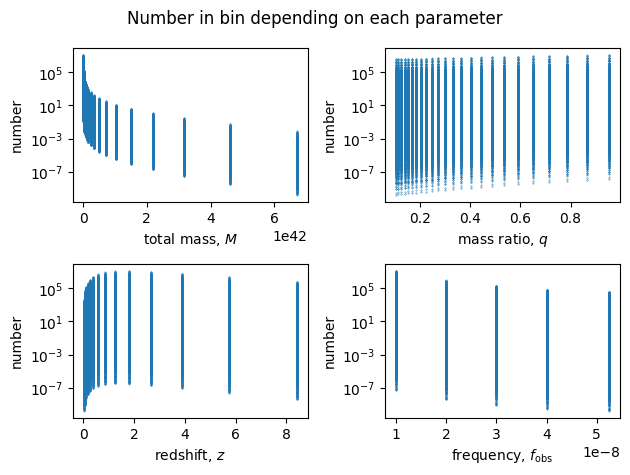

In [ ]:

fig, axs = plt.subplots(2,2)

fig.suptitle('Number in bin depending on each parameter')
axs[0,0].scatter(masses, numbers, s=.1)
axs[0,0].set_xlabel('total mass, $M$')
axs[0,0].set_ylabel('number')
axs[0,0].set_yscale('log')

axs[0,1].scatter(ratios, numbers, s=.1)
axs[0,1].set_xlabel('mass ratio, $q$')
axs[0,1].set_ylabel('number')
axs[0,1].set_yscale('log')

axs[1,0].scatter(shifts, numbers, s=.1)
axs[1,0].set_xlabel('redshift, $z$')
axs[1,0].set_ylabel('number')
axs[1,0].set_yscale('log')

axs[1,1].scatter(ofreqs, numbers, s=.1)
axs[1,1].set_xlabel('frequency, $f_\mathrm{obs}$')
axs[1,1].set_ylabel('number')
axs[1,1].set_yscale('log')

fig.tight_layout()

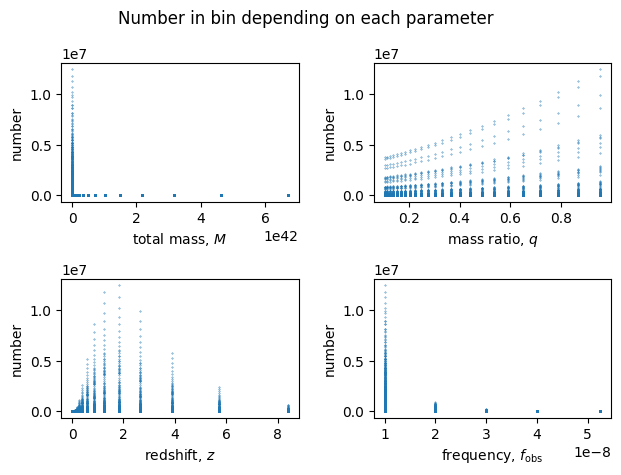

In [ ]:

fig, axs = plt.subplots(2,2)

fig.suptitle('Number in bin depending on each parameter')
axs[0,0].scatter(masses, numbers, s=.1)
axs[0,0].set_xlabel('total mass, $M$')
axs[0,0].set_ylabel('number')
# axs[0,0].set_yscale('log')

axs[0,1].scatter(ratios, numbers, s=.1)
axs[0,1].set_xlabel('mass ratio, $q$')
axs[0,1].set_ylabel('number')
# axs[0,1].set_yscale('log')

axs[1,0].scatter(shifts, numbers, s=.1)
axs[1,0].set_xlabel('redshift, $z$')
axs[1,0].set_ylabel('number')
# axs[1,0].set_yscale('log')

axs[1,1].scatter(ofreqs, numbers, s=.1)
axs[1,1].set_xlabel('frequency, $f_\mathrm{obs}$')
axs[1,1].set_ylabel('number')
# axs[1,1].set_yscale('log')

fig.tight_layout()

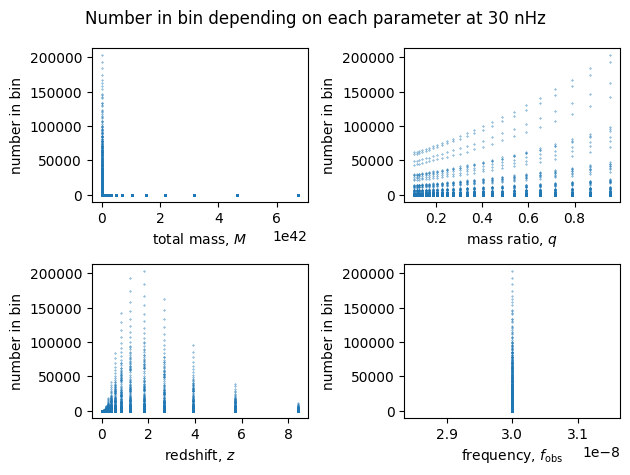

In [ ]:
masses_grid = (mt[:,np.newaxis,np.newaxis,np.newaxis]*ones)
ratios_grid = (mr[np.newaxis,:,np.newaxis,np.newaxis]*ones)
shifts_grid = (rz[np.newaxis,np.newaxis,:,np.newaxis]*ones)
ofreqs_grid = (fc[np.newaxis,np.newaxis,np.newaxis,:]*ones)
strains_grid = hc_loopF
numbers_grid = number

fig, axs = plt.subplots(2,2)

fig.suptitle('Number in bin depending on each parameter at %d nHz' % (ofreqs_grid[0,0,0,2]*10**9))
axs[0,0].scatter(masses[:,:,:,2], numbers[:,:,:,2], s=.1)
axs[0,0].set_xlabel('total mass, $M$')
axs[0,0].set_ylabel('number in bin')

axs[0,1].scatter(ratios[:,:,:,2], numbers[:,:,:,2], s=.1)
axs[0,1].set_xlabel('mass ratio, $q$')
axs[0,1].set_ylabel('number in bin')


axs[1,0].scatter(shifts[:,:,:,2], numbers[:,:,:,2], s=.1)
axs[1,0].set_xlabel('redshift, $z$')
axs[1,0].set_ylabel('number in bin')


axs[1,1].scatter(ofreqs[:,:,:,2], numbers[:,:,:,2], s=.1)
axs[1,1].set_xlabel('frequency, $f_\mathrm{obs}$')
axs[1,1].set_ylabel('number in bin')

fig.tight_layout()

In [ ]:


fig, axs = plt.subplots(2,2)

fig.suptitle('Number vs Mass with dif other params')
axs[0,0].scatter(mass_grid[], number_grid[], s=.1)
axs[0,0].set_xlabel('total mass, $M$')
axs[0,0].set_ylabel('number in bin')

axs[0,1].scatter(ratios, numbers, s=.1)
axs[0,1].set_xlabel('mass ratio')
axs[0,1].set_ylabel('strain of bin')


axs[1,0].scatter(shifts, numbers, s=.1)
axs[1,0].set_xlabel('redshift')
axs[1,0].set_ylabel('strain of bin')


axs[1,1].scatter(ofreqs, numbers, s=.1)
axs[1,1].set_xlabel('frequency')
axs[1,1].set_ylabel('strain of bin')

fig.tight_layout()